In [ ]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("manideep1108/tusimple")

# print("Path to dataset files:", path)

100%|██████████| 21.6G/21.6G [03:21<00:00, 116MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/manideep1108/tusimple/versions/5


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from pathlib import Path
from tqdm.notebook import tqdm


In [2]:
import os
import shutil

clips = r'C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\old_dataset\TUSimple\train_set\clips'
new_frames = r'C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\new_dataset\training\images'

# Create the target directory if it doesn't exist
os.makedirs(new_frames, exist_ok=True)

for i in os.listdir(clips):
    for j in os.listdir(os.path.join(clips, i)):
        frame = os.path.join(clips, i, j, '20.jpg')

        # Ensure the frame exists before proceeding
        if not os.path.exists(frame):
            print(f"[WARNING] Frame not found: {frame}")
            continue

        # Use directory names safely
        new_fn = f'{i}_{j}.jpg'
        new_file = os.path.join(new_frames, new_fn)

        shutil.copy(frame, new_file)
    print('Done with:', i)

Done with: 0313-1
Done with: 0313-2
Done with: 0531
Done with: 0601


In [6]:
def generate_lane_mask(row, training_set=True):
    '''
        Generates and writes the corresponding lane masks for the given images
    '''
    # create a mask of all zeros
    mask = np.zeros((720, 1280, 3))
    h_samples = row.h_samples
    lanes = row.lanes
    raw_file = row.raw_file

    # create mask: lane: 1, non-lane: 0
    for lane in lanes:
        '''
        -2 indicates no line in the specified point, so we omit the points from lane markings list
        '''
        h_samples_updated = [y for x, y in zip(lane, h_samples) if x != -2]
        lane = [x for x in lane if x != -2]
        lane_points = np.array(list(zip(lane, h_samples_updated)))
        # add lane markings to the mask we created
        cv2.polylines(mask, [lane_points], False, (255, 255, 255), thickness=15)

        # write the lane mask to the desired directory
        if training_set:
            path = r'C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\new_dataset\training\masks'
        else:
            path = r'C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\new_dataset\training\masks'
        '''
            name each mask according to its image's name.
            e.g. 'clips/0531/1492629775931278791/20.jpg' becomes '0531_1492629775931278791.jpg'
        '''
        tmp = raw_file[:-7].split('/')[-2:]
        mask_fname = f'{tmp[0]}_{tmp[1]}.jpg'
        new_file = os.path.join(path, mask_fname)
        cv2.imwrite(new_file, mask)
    return mask_fname

In [7]:
df_0601 = pd.read_json(r'C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\old_dataset\TUSimple\train_set\label_data_0601.json', lines=True)
df_0313 = pd.read_json(r'C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\old_dataset\TUSimple\train_set\label_data_0313.json', lines=True)
df_0531 = pd.read_json(r'C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\old_dataset\TUSimple\train_set\label_data_0531.json', lines=True)
df = pd.concat([df_0601, df_0313, df_0531])

In [8]:
# generate masks based on the json files above
for index, row in df.iterrows():
    # generate the lane mask for each frame
    generate_lane_mask(row)
    if index%200 == 0:
        print('Row: ', index)

Row:  0
Row:  200
Row:  400
Row:  0
Row:  200
Row:  400
Row:  600
Row:  800
Row:  1000
Row:  1200
Row:  1400
Row:  1600
Row:  1800
Row:  2000
Row:  2200
Row:  2400
Row:  2600
Row:  2800
Row:  0
Row:  200


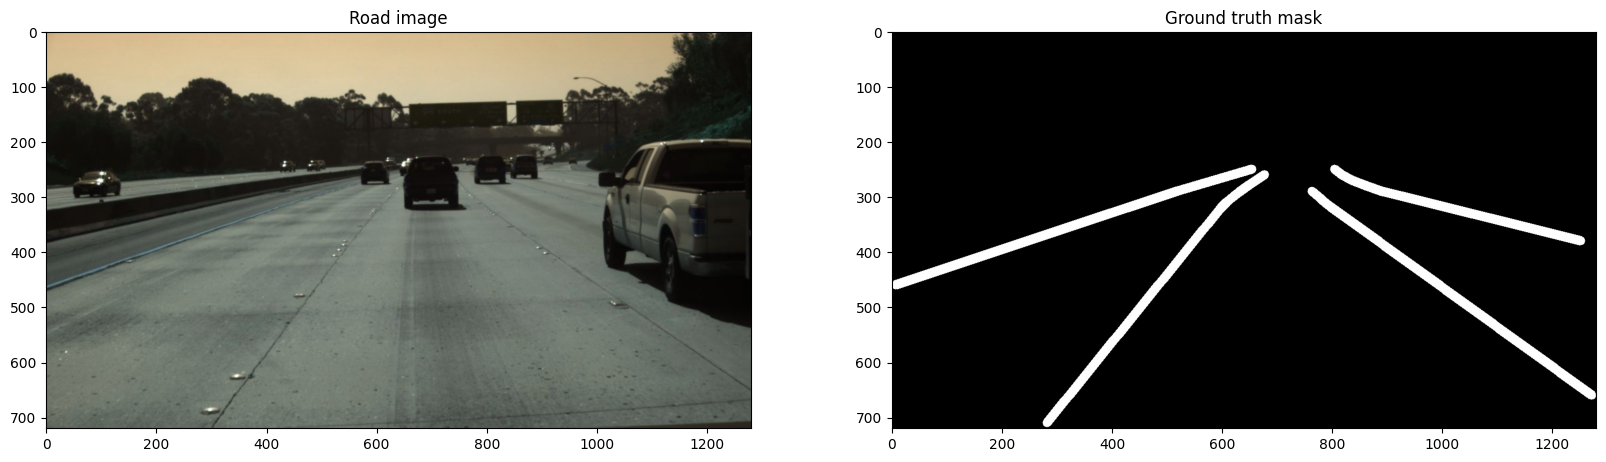

In [ ]:
img_mask = cv2.imread(r'/New_dataset/training/masks/0313-1_11120.jpg')
img_color = cv2.imread(r'/New_dataset/training/images/0313-1_11120.jpg')

# training set
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.imshow(img_color/255.)
plt.title('Road image')

plt.subplot(1, 2, 2)
plt.imshow(img_mask/255., cmap='gray')
plt.title('Ground truth mask')



plt.show()

In [ ]:
# check if we have the same image-mask pairs in the training set
images_path = r'C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\new_dataset\training\images'
masks_path = r'C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\new_dataset\training\masks'
assert os.listdir(images_path) == os.listdir(masks_path)

In [ ]:
# --- Configuration ---
# Define the base directory for your data
base_dir = Path(r'C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\new_dataset\training')

images_src_dir = base_dir / 'images'
masks_src_dir = base_dir / 'masks'


image_extension = '.jpg'
mask_extension = '.jpg'


# --- Consistency Check ---
all_image_files = [f for f in os.listdir(images_src_dir) if f.endswith(image_extension)]
print(f"Checking for inconsistencies across {len(all_image_files)} images...\n")


missing_masks = []

for filename in all_image_files:
    stem = Path(filename).stem

    # Check for corresponding mask file
    mask_path = masks_src_dir / (stem + mask_extension)
    if not mask_path.exists():
        missing_masks.append(filename)

print("--- Summary of Missing Files ---")

if missing_masks:
    print(f"\n{len(missing_masks)} images are missing mask files:")
    for file in missing_masks:
        print(f"- {file}")
else:
    print("\nNo images are missing mask files.")


In [ ]:

# --- GPU Verification ---
print("--- GPU Check ---")
print("TensorFlow Version:", tf.__version__)
gpu_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpu_devices))

if len(gpu_devices) > 0:
    # Set memory growth to True to avoid TensorFlow allocating all GPU memory at once
    try:
        for gpu in gpu_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth has been set.")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

    print("TensorFlow will use the following GPU:", gpu_devices[0].name)
else:
    print("\n--- WARNING ---")
    print("TensorFlow did NOT find a GPU. Training will run on the CPU, which will be very slow.")
    print("Please check your NVIDIA drivers, CUDA, and cuDNN installation.")

print("-" * 20)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
import albumentations as A

# --- 1. Load and Prepare Data Paths ---
# Define the path to your preprocessed dataset
# Make sure this path is correct for your environment (e.g., /kaggle/input/...)
DATA_DIR = r'C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\new_dataset\training'

# Load the image and mask paths, ensuring they are sorted to maintain alignment
image_paths = sorted([os.path.join(DATA_DIR, 'images', fname) for fname in os.listdir(os.path.join(DATA_DIR, 'images'))])
mask_paths = sorted([os.path.join(DATA_DIR, 'masks', fname) for fname in os.listdir(os.path.join(DATA_DIR, 'masks'))])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

print(f"Total samples: {len(image_paths)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")

In [ ]:
# --- 2. Data Augmentation Pipeline ---
def get_training_augmentation():
    """Defines a strong augmentation pipeline for training."""
    train_transform = [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=10, shift_limit=0.1, p=0.7, border_mode=cv2.BORDER_CONSTANT),
        A.RandomBrightnessContrast(p=0.8),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.8),
        A.GaussNoise(p=0.2),
        A.OneOf(
            [
                A.Blur(blur_limit=3, p=0.5),
                A.ColorJitter(p=0.5),
            ],
            p=1.0,
        ),
    ]
    return A.Compose(train_transform)


# --- 3. Data Generator Class ---
class DataGenerator(keras.utils.Sequence):
    """Generates data for Keras, applying augmentations on the fly."""
    def __init__(self, image_paths, mask_paths, batch_size=16, image_size=(128, 256), augmentations=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.image_size = image_size # Stored as (height, width)
        self.augmentations = augmentations

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_image_paths = self.image_paths[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[idx * self.batch_size : (idx + 1) * self.batch_size]

        images = []
        masks = []

        # Define the target size for OpenCV in (width, height) format
        cv2_dsize = (self.image_size[1], self.image_size[0])

        for img_path, mask_path in zip(batch_image_paths, batch_mask_paths):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # CORRECTED LINE: Use the (width, height) tuple for resizing
            img = cv2.resize(img, cv2_dsize)

            mask = cv2.imread(mask_path, 0) # Load as grayscale
            # CORRECTED LINE: Use the (width, height) tuple for resizing
            mask = cv2.resize(mask, cv2_dsize)
            mask = np.expand_dims(mask, axis=-1)

            if self.augmentations:
                augmented = self.augmentations(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']

            images.append(img)
            masks.append(mask)

        # Normalize pixel values to [0, 1]
        return np.array(images, dtype=np.float32) / 255.0, np.array(masks, dtype=np.float32) / 255.0

# Create the data generators
train_gen = DataGenerator(X_train, y_train, augmentations=get_training_augmentation())
val_gen = DataGenerator(X_val, y_val)

In [ ]:
# --- 4. U-Net Model Architecture ---
def conv_block(input_tensor, num_filters):
    x = layers.Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(num_filters, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = layers.concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.Model(inputs, outputs, name="U-Net")
    return model

# --- 5. Custom Loss and Metric ---
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def iou(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


# --- 6. Custom Callback for Epoch Logging ---
class EpochLogger(keras.callbacks.Callback):
    """A custom callback to log metrics and model saving status at the end of each epoch."""
    def __init__(self, filepath):
        super(EpochLogger, self).__init__()
        self.filepath = filepath
        # CORRECTED LINE: Use np.inf (lowercase) instead of np.Inf
        self.best_val_loss = np.inf

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        val_iou = logs.get('val_iou')
        loss = logs.get('loss')
        model_iou = logs.get('iou')
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')


        print(f"\nEpoch {epoch + 1:02d}: Loss: {loss:.4f}, IoU: {model_iou:.4f}, Accuracy: {accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation IoU: {val_iou:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if val_loss < self.best_val_loss:
            print(f"  - Validation loss improved from {self.best_val_loss:.4f} to {val_loss:.4f}.")
            print(f"  - Model saved to: {self.filepath}")
            self.best_val_loss = val_loss
        else:
            print(f"  - Validation loss did not improve from {self.best_val_loss:.4f}.")

# --- 7. Instantiate and Compile Model ---
input_shape = (128, 256, 3)
model = build_unet(input_shape)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss=bce_dice_loss,
              metrics=[iou, 'accuracy']) # Added accuracy as a metric

model.summary()

In [34]:
# --- 8. Define Callbacks and Train the Model ---

# Define the path where the best model will be saved
model_save_path = "unet_road_lane_best.h5"

callbacks = [
    # This callback saves the model only when `val_loss` improves. `save_best_only=True` is key.
    keras.callbacks.ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=0),

    # This is our custom logger to provide clear, epoch-by-epoch feedback.
    EpochLogger(filepath=model_save_path),

    # Reduce learning rate when validation loss plateaus
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6, verbose=1),

    # Stop training early if there's no improvement to prevent overfitting
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
]

# Set the number of epochs for training
EPOCHS = 200

print("\n--- Starting Model Training ---")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("\n--- Finished Model Training ---")


--- Starting Model Training ---
Epoch 1/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.8325 - iou: 0.0544 - loss: 1.3089


Epoch 01: Loss: 1.1422, IoU: 0.0763, Accuracy: 0.9041, Validation Loss: 1.1468, Validation IoU: 0.0449, Validation Accuracy: 0.9449
  - Validation loss improved from inf to 1.1468.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 122s 563ms/step - accuracy: 0.8329 - iou: 0.0545 - loss: 1.3080 - val_accuracy: 0.9449 - val_iou: 0.0449 - val_loss: 1.1468 - learning_rate: 1.0000e-04
Epoch 2/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9322 - iou: 0.1563 - loss: 0.9028


Epoch 02: Loss: 0.8617, IoU: 0.1772, Accuracy: 0.9345, Validation Loss: 0.7859, Validation IoU: 0.2299, Validation Accuracy: 0.9371
  - Validation loss improved from 1.1468 to 0.7859.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 96s 532ms/step - accuracy: 0.9322 - iou: 0.1564 - loss: 0.9026 - val_accuracy: 0.9371 - val_iou: 0.2299 - val_loss: 0.7859 - learning_rate: 1.0000e-04
Epoch 3/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9403 - iou: 0.2316 - loss: 0.7609


Epoch 03: Loss: 0.7363, IoU: 0.2460, Accuracy: 0.9420, Validation Loss: 0.6297, Validation IoU: 0.3217, Validation Accuracy: 0.9475
  - Validation loss improved from 0.7859 to 0.6297.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 140s 523ms/step - accuracy: 0.9403 - iou: 0.2316 - loss: 0.7608 - val_accuracy: 0.9475 - val_iou: 0.3217 - val_loss: 0.6297 - learning_rate: 1.0000e-04
Epoch 4/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9456 - iou: 0.2897 - loss: 0.6686


Epoch 04: Loss: 0.6501, IoU: 0.3018, Accuracy: 0.9469, Validation Loss: 0.5403, Validation IoU: 0.3853, Validation Accuracy: 0.9522
  - Validation loss improved from 0.6297 to 0.5403.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 94s 517ms/step - accuracy: 0.9456 - iou: 0.2898 - loss: 0.6685 - val_accuracy: 0.9522 - val_iou: 0.3853 - val_loss: 0.5403 - learning_rate: 1.0000e-04
Epoch 5/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9495 - iou: 0.3371 - loss: 0.6008


Epoch 05: Loss: 0.5926, IoU: 0.3435, Accuracy: 0.9495, Validation Loss: 0.4890, Validation IoU: 0.4265, Validation Accuracy: 0.9543
  - Validation loss improved from 0.5403 to 0.4890.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 95s 525ms/step - accuracy: 0.9495 - iou: 0.3372 - loss: 0.6008 - val_accuracy: 0.9543 - val_iou: 0.4265 - val_loss: 0.4890 - learning_rate: 1.0000e-04
Epoch 6/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9511 - iou: 0.3679 - loss: 0.5617


Epoch 06: Loss: 0.5518, IoU: 0.3760, Accuracy: 0.9513, Validation Loss: 0.4439, Validation IoU: 0.4685, Validation Accuracy: 0.9555
  - Validation loss improved from 0.4890 to 0.4439.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 91s 503ms/step - accuracy: 0.9511 - iou: 0.3679 - loss: 0.5616 - val_accuracy: 0.9555 - val_iou: 0.4685 - val_loss: 0.4439 - learning_rate: 1.0000e-04
Epoch 7/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9522 - iou: 0.3978 - loss: 0.5261


Epoch 07: Loss: 0.5208, IoU: 0.4021, Accuracy: 0.9525, Validation Loss: 0.4350, Validation IoU: 0.4795, Validation Accuracy: 0.9552
  - Validation loss improved from 0.4439 to 0.4350.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 95s 522ms/step - accuracy: 0.9522 - iou: 0.3978 - loss: 0.5261 - val_accuracy: 0.9552 - val_iou: 0.4795 - val_loss: 0.4350 - learning_rate: 1.0000e-04
Epoch 8/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9527 - iou: 0.4125 - loss: 0.5093


Epoch 08: Loss: 0.4985, IoU: 0.4215, Accuracy: 0.9534, Validation Loss: 0.4056, Validation IoU: 0.5033, Validation Accuracy: 0.9568
  - Validation loss improved from 0.4350 to 0.4056.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 96s 530ms/step - accuracy: 0.9527 - iou: 0.4125 - loss: 0.5093 - val_accuracy: 0.9568 - val_iou: 0.5033 - val_loss: 0.4056 - learning_rate: 1.0000e-04
Epoch 9/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9540 - iou: 0.4343 - loss: 0.4841


Epoch 09: Loss: 0.4803, IoU: 0.4379, Accuracy: 0.9541, Validation Loss: 0.3919, Validation IoU: 0.5199, Validation Accuracy: 0.9566
  - Validation loss improved from 0.4056 to 0.3919.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 140s 520ms/step - accuracy: 0.9540 - iou: 0.4343 - loss: 0.4841 - val_accuracy: 0.9566 - val_iou: 0.5199 - val_loss: 0.3919 - learning_rate: 1.0000e-04
Epoch 10/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9545 - iou: 0.4476 - loss: 0.4699


Epoch 10: Loss: 0.4644, IoU: 0.4525, Accuracy: 0.9548, Validation Loss: 0.3744, Validation IoU: 0.5369, Validation Accuracy: 0.9573
  - Validation loss improved from 0.3919 to 0.3744.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 95s 524ms/step - accuracy: 0.9545 - iou: 0.4476 - loss: 0.4699 - val_accuracy: 0.9573 - val_iou: 0.5369 - val_loss: 0.3744 - learning_rate: 1.0000e-04
Epoch 11/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9557 - iou: 0.4669 - loss: 0.4482
Epoch 11: Loss: 0.4516, IoU: 0.4645, Accuracy: 0.9555, Validation Loss: 0.3771, Validation IoU: 0.5369, Validation Accuracy: 0.9569
  - Validation loss did not improve from 0.3744.
181/181 ━━━━━━━━━━━━━━━━━━━━ 88s 488ms/step - accuracy: 0.9557 - iou: 0.4669 - loss: 0.4482 - val_accuracy: 0.9569 - val_iou: 0.5369 - val_loss: 0.3771 - learning_rate: 1.0000e-04
Epoch 12/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9554 - iou: 0.4698 - loss: 0.4471


Epoch 12: Loss: 0.4424, IoU: 0.4736, Accuracy: 0.9558, Validation Loss: 0.3620, Validation IoU: 0.5522, Validation Accuracy: 0.9582
  - Validation loss improved from 0.3744 to 0.3620.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 99s 546ms/step - accuracy: 0.9554 - iou: 0.4698 - loss: 0.4470 - val_accuracy: 0.9582 - val_iou: 0.5522 - val_loss: 0.3620 - learning_rate: 1.0000e-04
Epoch 13/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9560 - iou: 0.4777 - loss: 0.4380


Epoch 13: Loss: 0.4369, IoU: 0.4789, Accuracy: 0.9559, Validation Loss: 0.3496, Validation IoU: 0.5625, Validation Accuracy: 0.9587
  - Validation loss improved from 0.3620 to 0.3496.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 142s 544ms/step - accuracy: 0.9560 - iou: 0.4777 - loss: 0.4380 - val_accuracy: 0.9587 - val_iou: 0.5625 - val_loss: 0.3496 - learning_rate: 1.0000e-04
Epoch 14/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9560 - iou: 0.4799 - loss: 0.4363


Epoch 14: Loss: 0.4301, IoU: 0.4856, Accuracy: 0.9562, Validation Loss: 0.3419, Validation IoU: 0.5692, Validation Accuracy: 0.9591
  - Validation loss improved from 0.3496 to 0.3419.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 95s 525ms/step - accuracy: 0.9560 - iou: 0.4800 - loss: 0.4362 - val_accuracy: 0.9591 - val_iou: 0.5692 - val_loss: 0.3419 - learning_rate: 1.0000e-04
Epoch 15/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9566 - iou: 0.4960 - loss: 0.4190


Epoch 15: Loss: 0.4187, IoU: 0.4963, Accuracy: 0.9567, Validation Loss: 0.3394, Validation IoU: 0.5729, Validation Accuracy: 0.9591
  - Validation loss improved from 0.3419 to 0.3394.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 99s 547ms/step - accuracy: 0.9566 - iou: 0.4960 - loss: 0.4190 - val_accuracy: 0.9591 - val_iou: 0.5729 - val_loss: 0.3394 - learning_rate: 1.0000e-04
Epoch 16/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9572 - iou: 0.4990 - loss: 0.4161
Epoch 16: Loss: 0.4184, IoU: 0.4969, Accuracy: 0.9569, Validation Loss: 0.3406, Validation IoU: 0.5741, Validation Accuracy: 0.9589
  - Validation loss did not improve from 0.3394.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 490ms/step - accuracy: 0.9571 - iou: 0.4990 - loss: 0.4161 - val_accuracy: 0.9589 - val_iou: 0.5741 - val_loss: 0.3406 - learning_rate: 1.0000e-04
Epoch 17/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9571 - iou: 0.5050 - loss: 0.4096


Epoch 17: Loss: 0.4146, IoU: 0.5008, Accuracy: 0.9567, Validation Loss: 0.3339, Validation IoU: 0.5799, Validation Accuracy: 0.9594
  - Validation loss improved from 0.3394 to 0.3339.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 96s 530ms/step - accuracy: 0.9571 - iou: 0.5050 - loss: 0.4097 - val_accuracy: 0.9594 - val_iou: 0.5799 - val_loss: 0.3339 - learning_rate: 1.0000e-04
Epoch 18/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9572 - iou: 0.5049 - loss: 0.4101
Epoch 18: Loss: 0.4081, IoU: 0.5067, Accuracy: 0.9573, Validation Loss: 0.3341, Validation IoU: 0.5797, Validation Accuracy: 0.9590
  - Validation loss did not improve from 0.3339.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 488ms/step - accuracy: 0.9572 - iou: 0.5049 - loss: 0.4101 - val_accuracy: 0.9590 - val_iou: 0.5797 - val_loss: 0.3341 - learning_rate: 1.0000e-04
Epoch 19/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9574 - iou: 0.5102 - loss: 0.4043


Epoch 19: Loss: 0.4015, IoU: 0.5130, Accuracy: 0.9576, Validation Loss: 0.3225, Validation IoU: 0.5900, Validation Accuracy: 0.9598
  - Validation loss improved from 0.3339 to 0.3225.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 96s 529ms/step - accuracy: 0.9574 - iou: 0.5103 - loss: 0.4043 - val_accuracy: 0.9598 - val_iou: 0.5900 - val_loss: 0.3225 - learning_rate: 1.0000e-04
Epoch 20/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9574 - iou: 0.5101 - loss: 0.4047
Epoch 20: Loss: 0.4032, IoU: 0.5120, Accuracy: 0.9573, Validation Loss: 0.3283, Validation IoU: 0.5892, Validation Accuracy: 0.9592
  - Validation loss did not improve from 0.3225.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 488ms/step - accuracy: 0.9574 - iou: 0.5101 - loss: 0.4047 - val_accuracy: 0.9592 - val_iou: 0.5892 - val_loss: 0.3283 - learning_rate: 1.0000e-04
Epoch 21/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9572 - iou: 0.5128 - loss: 0.4026


Epoch 21: Loss: 0.4013, IoU: 0.5134, Accuracy: 0.9575, Validation Loss: 0.3213, Validation IoU: 0.5929, Validation Accuracy: 0.9602
  - Validation loss improved from 0.3225 to 0.3213.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 100s 551ms/step - accuracy: 0.9572 - iou: 0.5128 - loss: 0.4026 - val_accuracy: 0.9602 - val_iou: 0.5929 - val_loss: 0.3213 - learning_rate: 1.0000e-04
Epoch 22/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9577 - iou: 0.5174 - loss: 0.3971
Epoch 22: Loss: 0.3945, IoU: 0.5199, Accuracy: 0.9579, Validation Loss: 0.3218, Validation IoU: 0.5943, Validation Accuracy: 0.9599
  - Validation loss did not improve from 0.3213.
181/181 ━━━━━━━━━━━━━━━━━━━━ 91s 504ms/step - accuracy: 0.9577 - iou: 0.5174 - loss: 0.3970 - val_accuracy: 0.9599 - val_iou: 0.5943 - val_loss: 0.3218 - learning_rate: 1.0000e-04
Epoch 23/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9578 - iou: 0.5198 - loss: 0.3952


Epoch 23: Loss: 0.3941, IoU: 0.5207, Accuracy: 0.9579, Validation Loss: 0.3174, Validation IoU: 0.5951, Validation Accuracy: 0.9601
  - Validation loss improved from 0.3213 to 0.3174.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 99s 546ms/step - accuracy: 0.9578 - iou: 0.5198 - loss: 0.3952 - val_accuracy: 0.9601 - val_iou: 0.5951 - val_loss: 0.3174 - learning_rate: 1.0000e-04
Epoch 24/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9580 - iou: 0.5201 - loss: 0.3945
Epoch 24: Loss: 0.3894, IoU: 0.5249, Accuracy: 0.9582, Validation Loss: 0.3209, Validation IoU: 0.5941, Validation Accuracy: 0.9599
  - Validation loss did not improve from 0.3174.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 488ms/step - accuracy: 0.9580 - iou: 0.5201 - loss: 0.3944 - val_accuracy: 0.9599 - val_iou: 0.5941 - val_loss: 0.3209 - learning_rate: 1.0000e-04
Epoch 25/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.9583 - iou: 0.5304 - loss: 0.3839


Epoch 25: Loss: 0.3845, IoU: 0.5296, Accuracy: 0.9585, Validation Loss: 0.3174, Validation IoU: 0.5985, Validation Accuracy: 0.9603
  - Validation loss improved from 0.3174 to 0.3174.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 97s 536ms/step - accuracy: 0.9583 - iou: 0.5304 - loss: 0.3839 - val_accuracy: 0.9603 - val_iou: 0.5985 - val_loss: 0.3174 - learning_rate: 1.0000e-04
Epoch 26/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9585 - iou: 0.5301 - loss: 0.3839
Epoch 26: Loss: 0.3837, IoU: 0.5302, Accuracy: 0.9585, Validation Loss: 0.3245, Validation IoU: 0.5920, Validation Accuracy: 0.9598
  - Validation loss did not improve from 0.3174.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 489ms/step - accuracy: 0.9585 - iou: 0.5301 - loss: 0.3839 - val_accuracy: 0.9598 - val_iou: 0.5920 - val_loss: 0.3245 - learning_rate: 1.0000e-04
Epoch 27/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9586 - iou: 0.5338 - loss: 0.3800
Epoch 27: Loss: 0.3787,


Epoch 28: Loss: 0.3746, IoU: 0.5391, Accuracy: 0.9588, Validation Loss: 0.3125, Validation IoU: 0.6024, Validation Accuracy: 0.9604
  - Validation loss improved from 0.3174 to 0.3125.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 101s 556ms/step - accuracy: 0.9587 - iou: 0.5378 - loss: 0.3758 - val_accuracy: 0.9604 - val_iou: 0.6024 - val_loss: 0.3125 - learning_rate: 1.0000e-04
Epoch 29/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9591 - iou: 0.5432 - loss: 0.3703


Epoch 29: Loss: 0.3720, IoU: 0.5418, Accuracy: 0.9591, Validation Loss: 0.3108, Validation IoU: 0.6062, Validation Accuracy: 0.9603
  - Validation loss improved from 0.3125 to 0.3108.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 136s 524ms/step - accuracy: 0.9591 - iou: 0.5432 - loss: 0.3704 - val_accuracy: 0.9603 - val_iou: 0.6062 - val_loss: 0.3108 - learning_rate: 1.0000e-04
Epoch 30/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9591 - iou: 0.5429 - loss: 0.3709


Epoch 30: Loss: 0.3723, IoU: 0.5415, Accuracy: 0.9591, Validation Loss: 0.3092, Validation IoU: 0.6073, Validation Accuracy: 0.9607
  - Validation loss improved from 0.3108 to 0.3092.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 98s 539ms/step - accuracy: 0.9591 - iou: 0.5429 - loss: 0.3709 - val_accuracy: 0.9607 - val_iou: 0.6073 - val_loss: 0.3092 - learning_rate: 1.0000e-04
Epoch 31/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9586 - iou: 0.5379 - loss: 0.3765


Epoch 31: Loss: 0.3719, IoU: 0.5420, Accuracy: 0.9590, Validation Loss: 0.3082, Validation IoU: 0.6103, Validation Accuracy: 0.9608
  - Validation loss improved from 0.3092 to 0.3082.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 95s 524ms/step - accuracy: 0.9586 - iou: 0.5379 - loss: 0.3764 - val_accuracy: 0.9608 - val_iou: 0.6103 - val_loss: 0.3082 - learning_rate: 1.0000e-04
Epoch 32/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9593 - iou: 0.5464 - loss: 0.3678


Epoch 32: Loss: 0.3663, IoU: 0.5473, Accuracy: 0.9593, Validation Loss: 0.3070, Validation IoU: 0.6112, Validation Accuracy: 0.9605
  - Validation loss improved from 0.3082 to 0.3070.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 146s 546ms/step - accuracy: 0.9593 - iou: 0.5464 - loss: 0.3678 - val_accuracy: 0.9605 - val_iou: 0.6112 - val_loss: 0.3070 - learning_rate: 1.0000e-04
Epoch 33/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9594 - iou: 0.5464 - loss: 0.3679
Epoch 33: Loss: 0.3688, IoU: 0.5452, Accuracy: 0.9592, Validation Loss: 0.3084, Validation IoU: 0.6094, Validation Accuracy: 0.9607
  - Validation loss did not improve from 0.3070.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 490ms/step - accuracy: 0.9594 - iou: 0.5464 - loss: 0.3679 - val_accuracy: 0.9607 - val_iou: 0.6094 - val_loss: 0.3084 - learning_rate: 1.0000e-04
Epoch 34/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9596 - iou: 0.5481 - loss: 0.3651


Epoch 34: Loss: 0.3671, IoU: 0.5464, Accuracy: 0.9593, Validation Loss: 0.3021, Validation IoU: 0.6158, Validation Accuracy: 0.9611
  - Validation loss improved from 0.3070 to 0.3021.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 95s 522ms/step - accuracy: 0.9596 - iou: 0.5481 - loss: 0.3651 - val_accuracy: 0.9611 - val_iou: 0.6158 - val_loss: 0.3021 - learning_rate: 1.0000e-04
Epoch 35/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9596 - iou: 0.5526 - loss: 0.3609
Epoch 35: Loss: 0.3633, IoU: 0.5506, Accuracy: 0.9595, Validation Loss: 0.3067, Validation IoU: 0.6111, Validation Accuracy: 0.9606
  - Validation loss did not improve from 0.3021.
181/181 ━━━━━━━━━━━━━━━━━━━━ 136s 491ms/step - accuracy: 0.9596 - iou: 0.5526 - loss: 0.3609 - val_accuracy: 0.9606 - val_iou: 0.6111 - val_loss: 0.3067 - learning_rate: 1.0000e-04
Epoch 36/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9593 - iou: 0.5493 - loss: 0.3646
Epoch 36: Loss: 0.3669


Epoch 39: Loss: 0.3585, IoU: 0.5554, Accuracy: 0.9597, Validation Loss: 0.3009, Validation IoU: 0.6179, Validation Accuracy: 0.9609
  - Validation loss improved from 0.3021 to 0.3009.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 100s 555ms/step - accuracy: 0.9596 - iou: 0.5555 - loss: 0.3588 - val_accuracy: 0.9609 - val_iou: 0.6179 - val_loss: 0.3009 - learning_rate: 1.0000e-04
Epoch 40/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9601 - iou: 0.5604 - loss: 0.3531
Epoch 40: Loss: 0.3560, IoU: 0.5574, Accuracy: 0.9599, Validation Loss: 0.3017, Validation IoU: 0.6163, Validation Accuracy: 0.9609
  - Validation loss did not improve from 0.3009.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 490ms/step - accuracy: 0.9601 - iou: 0.5603 - loss: 0.3531 - val_accuracy: 0.9609 - val_iou: 0.6163 - val_loss: 0.3017 - learning_rate: 1.0000e-04
Epoch 41/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9598 - iou: 0.5590 - loss: 0.3551


Epoch 41: Loss: 0.3569, IoU: 0.5569, Accuracy: 0.9598, Validation Loss: 0.2984, Validation IoU: 0.6170, Validation Accuracy: 0.9612
  - Validation loss improved from 0.3009 to 0.2984.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 94s 521ms/step - accuracy: 0.9598 - iou: 0.5589 - loss: 0.3551 - val_accuracy: 0.9612 - val_iou: 0.6170 - val_loss: 0.2984 - learning_rate: 1.0000e-04
Epoch 42/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9599 - iou: 0.5595 - loss: 0.3539
Epoch 42: Loss: 0.3586, IoU: 0.5552, Accuracy: 0.9597, Validation Loss: 0.3072, Validation IoU: 0.6119, Validation Accuracy: 0.9608
  - Validation loss did not improve from 0.2984.
181/181 ━━━━━━━━━━━━━━━━━━━━ 88s 487ms/step - accuracy: 0.9599 - iou: 0.5594 - loss: 0.3539 - val_accuracy: 0.9608 - val_iou: 0.6119 - val_loss: 0.3072 - learning_rate: 1.0000e-04
Epoch 43/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9597 - iou: 0.5553 - loss: 0.3576
Epoch 43: Loss: 0.3563,


Epoch 45: Loss: 0.3454, IoU: 0.5679, Accuracy: 0.9604, Validation Loss: 0.2980, Validation IoU: 0.6203, Validation Accuracy: 0.9612
  - Validation loss improved from 0.2984 to 0.2980.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 94s 517ms/step - accuracy: 0.9603 - iou: 0.5671 - loss: 0.3464 - val_accuracy: 0.9612 - val_iou: 0.6203 - val_loss: 0.2980 - learning_rate: 1.0000e-04
Epoch 46/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9601 - iou: 0.5637 - loss: 0.3505


Epoch 46: Loss: 0.3500, IoU: 0.5636, Accuracy: 0.9601, Validation Loss: 0.2941, Validation IoU: 0.6256, Validation Accuracy: 0.9616
  - Validation loss improved from 0.2980 to 0.2941.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 99s 545ms/step - accuracy: 0.9601 - iou: 0.5637 - loss: 0.3505 - val_accuracy: 0.9616 - val_iou: 0.6256 - val_loss: 0.2941 - learning_rate: 1.0000e-04
Epoch 47/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9603 - iou: 0.5646 - loss: 0.3485
Epoch 47: Loss: 0.3508, IoU: 0.5625, Accuracy: 0.9601, Validation Loss: 0.2969, Validation IoU: 0.6215, Validation Accuracy: 0.9612
  - Validation loss did not improve from 0.2941.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 489ms/step - accuracy: 0.9603 - iou: 0.5646 - loss: 0.3485 - val_accuracy: 0.9612 - val_iou: 0.6215 - val_loss: 0.2969 - learning_rate: 1.0000e-04
Epoch 48/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9604 - iou: 0.5684 - loss: 0.3448
Epoch 48: Loss: 0.3482,


Epoch 52: Loss: 0.3277, IoU: 0.5856, Accuracy: 0.9614, Validation Loss: 0.2859, Validation IoU: 0.6327, Validation Accuracy: 0.9619
  - Validation loss improved from 0.2941 to 0.2859.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 97s 537ms/step - accuracy: 0.9613 - iou: 0.5829 - loss: 0.3311 - val_accuracy: 0.9619 - val_iou: 0.6327 - val_loss: 0.2859 - learning_rate: 1.0000e-05
Epoch 53/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9617 - iou: 0.5900 - loss: 0.3229


Epoch 53: Loss: 0.3235, IoU: 0.5897, Accuracy: 0.9616, Validation Loss: 0.2858, Validation IoU: 0.6334, Validation Accuracy: 0.9618
  - Validation loss improved from 0.2859 to 0.2858.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 95s 523ms/step - accuracy: 0.9617 - iou: 0.5900 - loss: 0.3229 - val_accuracy: 0.9618 - val_iou: 0.6334 - val_loss: 0.2858 - learning_rate: 1.0000e-05
Epoch 54/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9619 - iou: 0.5920 - loss: 0.3209


Epoch 54: Loss: 0.3172, IoU: 0.5962, Accuracy: 0.9618, Validation Loss: 0.2855, Validation IoU: 0.6337, Validation Accuracy: 0.9619
  - Validation loss improved from 0.2858 to 0.2855.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 100s 549ms/step - accuracy: 0.9619 - iou: 0.5920 - loss: 0.3209 - val_accuracy: 0.9619 - val_iou: 0.6337 - val_loss: 0.2855 - learning_rate: 1.0000e-05
Epoch 55/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9615 - iou: 0.5912 - loss: 0.3225
Epoch 55: Loss: 0.3206, IoU: 0.5928, Accuracy: 0.9617, Validation Loss: 0.2870, Validation IoU: 0.6325, Validation Accuracy: 0.9618
  - Validation loss did not improve from 0.2855.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 489ms/step - accuracy: 0.9615 - iou: 0.5912 - loss: 0.3224 - val_accuracy: 0.9618 - val_iou: 0.6325 - val_loss: 0.2870 - learning_rate: 1.0000e-05
Epoch 56/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9617 - iou: 0.5943 - loss: 0.3191
Epoch 56: Loss: 0.3199


Epoch 57: Loss: 0.3184, IoU: 0.5946, Accuracy: 0.9618, Validation Loss: 0.2842, Validation IoU: 0.6356, Validation Accuracy: 0.9620
  - Validation loss improved from 0.2855 to 0.2842.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 99s 545ms/step - accuracy: 0.9622 - iou: 0.5966 - loss: 0.3162 - val_accuracy: 0.9620 - val_iou: 0.6356 - val_loss: 0.2842 - learning_rate: 1.0000e-05
Epoch 58/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9619 - iou: 0.5995 - loss: 0.3139
Epoch 58: Loss: 0.3133, IoU: 0.6000, Accuracy: 0.9620, Validation Loss: 0.2844, Validation IoU: 0.6354, Validation Accuracy: 0.9619
  - Validation loss did not improve from 0.2842.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 489ms/step - accuracy: 0.9619 - iou: 0.5995 - loss: 0.3139 - val_accuracy: 0.9619 - val_iou: 0.6354 - val_loss: 0.2844 - learning_rate: 1.0000e-05
Epoch 59/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9620 - iou: 0.5967 - loss: 0.3167
Epoch 59: Loss: 0.3171,


Epoch 65: Loss: 0.3118, IoU: 0.6016, Accuracy: 0.9622, Validation Loss: 0.2839, Validation IoU: 0.6363, Validation Accuracy: 0.9620
  - Validation loss improved from 0.2842 to 0.2839.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 100s 551ms/step - accuracy: 0.9624 - iou: 0.6028 - loss: 0.3103 - val_accuracy: 0.9620 - val_iou: 0.6363 - val_loss: 0.2839 - learning_rate: 1.0000e-06
Epoch 66/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9624 - iou: 0.6064 - loss: 0.3068
Epoch 66: Loss: 0.3098, IoU: 0.6035, Accuracy: 0.9624, Validation Loss: 0.2839, Validation IoU: 0.6362, Validation Accuracy: 0.9620
  - Validation loss did not improve from 0.2839.
181/181 ━━━━━━━━━━━━━━━━━━━━ 134s 505ms/step - accuracy: 0.9624 - iou: 0.6064 - loss: 0.3068 - val_accuracy: 0.9620 - val_iou: 0.6362 - val_loss: 0.2839 - learning_rate: 1.0000e-06
Epoch 67/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9619 - iou: 0.5970 - loss: 0.3168


Epoch 67: Loss: 0.3131, IoU: 0.6002, Accuracy: 0.9622, Validation Loss: 0.2838, Validation IoU: 0.6365, Validation Accuracy: 0.9620
  - Validation loss improved from 0.2839 to 0.2838.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 95s 523ms/step - accuracy: 0.9619 - iou: 0.5971 - loss: 0.3168 - val_accuracy: 0.9620 - val_iou: 0.6365 - val_loss: 0.2838 - learning_rate: 1.0000e-06
Epoch 68/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9620 - iou: 0.6029 - loss: 0.3110
Epoch 68: Loss: 0.3123, IoU: 0.6013, Accuracy: 0.9621, Validation Loss: 0.2840, Validation IoU: 0.6364, Validation Accuracy: 0.9620
  - Validation loss did not improve from 0.2838.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 489ms/step - accuracy: 0.9620 - iou: 0.6029 - loss: 0.3110 - val_accuracy: 0.9620 - val_iou: 0.6364 - val_loss: 0.2840 - learning_rate: 1.0000e-06
Epoch 69/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9624 - iou: 0.6057 - loss: 0.3074


Epoch 69: Loss: 0.3090, IoU: 0.6046, Accuracy: 0.9623, Validation Loss: 0.2837, Validation IoU: 0.6366, Validation Accuracy: 0.9620
  - Validation loss improved from 0.2838 to 0.2837.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 103s 570ms/step - accuracy: 0.9624 - iou: 0.6057 - loss: 0.3074 - val_accuracy: 0.9620 - val_iou: 0.6366 - val_loss: 0.2837 - learning_rate: 1.0000e-06
Epoch 70/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9622 - iou: 0.6000 - loss: 0.3134


Epoch 70: Loss: 0.3110, IoU: 0.6023, Accuracy: 0.9622, Validation Loss: 0.2836, Validation IoU: 0.6367, Validation Accuracy: 0.9620
  - Validation loss improved from 0.2837 to 0.2836.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 134s 527ms/step - accuracy: 0.9622 - iou: 0.6000 - loss: 0.3134 - val_accuracy: 0.9620 - val_iou: 0.6367 - val_loss: 0.2836 - learning_rate: 1.0000e-06
Epoch 71/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9623 - iou: 0.6032 - loss: 0.3101
Epoch 71: Loss: 0.3111, IoU: 0.6023, Accuracy: 0.9622, Validation Loss: 0.2840, Validation IoU: 0.6363, Validation Accuracy: 0.9620
  - Validation loss did not improve from 0.2836.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 490ms/step - accuracy: 0.9623 - iou: 0.6032 - loss: 0.3101 - val_accuracy: 0.9620 - val_iou: 0.6363 - val_loss: 0.2840 - learning_rate: 1.0000e-06
Epoch 72/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9626 - iou: 0.6091 - loss: 0.3042
Epoch 72: Loss: 0.3089


Epoch 73: Loss: 0.3106, IoU: 0.6029, Accuracy: 0.9622, Validation Loss: 0.2836, Validation IoU: 0.6366, Validation Accuracy: 0.9620
  - Validation loss improved from 0.2836 to 0.2836.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 95s 522ms/step - accuracy: 0.9619 - iou: 0.6011 - loss: 0.3128 - val_accuracy: 0.9620 - val_iou: 0.6366 - val_loss: 0.2836 - learning_rate: 1.0000e-06
Epoch 74/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9624 - iou: 0.6053 - loss: 0.3078
Epoch 74: Loss: 0.3095, IoU: 0.6037, Accuracy: 0.9623, Validation Loss: 0.2837, Validation IoU: 0.6366, Validation Accuracy: 0.9620
  - Validation loss did not improve from 0.2836.
181/181 ━━━━━━━━━━━━━━━━━━━━ 91s 503ms/step - accuracy: 0.9624 - iou: 0.6053 - loss: 0.3078 - val_accuracy: 0.9620 - val_iou: 0.6366 - val_loss: 0.2837 - learning_rate: 1.0000e-06
Epoch 75/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9624 - iou: 0.6065 - loss: 0.3069
Epoch 75: Loss: 0.3095,


Epoch 79: Loss: 0.3115, IoU: 0.6018, Accuracy: 0.9622, Validation Loss: 0.2836, Validation IoU: 0.6368, Validation Accuracy: 0.9620
  - Validation loss improved from 0.2836 to 0.2836.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 99s 546ms/step - accuracy: 0.9618 - iou: 0.5982 - loss: 0.3158 - val_accuracy: 0.9620 - val_iou: 0.6368 - val_loss: 0.2836 - learning_rate: 1.0000e-06
Epoch 80/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9623 - iou: 0.6071 - loss: 0.3062
Epoch 80: Loss: 0.3095, IoU: 0.6036, Accuracy: 0.9623, Validation Loss: 0.2836, Validation IoU: 0.6369, Validation Accuracy: 0.9620
  - Validation loss did not improve from 0.2836.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 489ms/step - accuracy: 0.9623 - iou: 0.6071 - loss: 0.3063 - val_accuracy: 0.9620 - val_iou: 0.6369 - val_loss: 0.2836 - learning_rate: 1.0000e-06
Epoch 81/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9624 - iou: 0.6060 - loss: 0.3074


Epoch 81: Loss: 0.3094, IoU: 0.6040, Accuracy: 0.9623, Validation Loss: 0.2835, Validation IoU: 0.6369, Validation Accuracy: 0.9620
  - Validation loss improved from 0.2836 to 0.2835.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 155s 562ms/step - accuracy: 0.9623 - iou: 0.6060 - loss: 0.3074 - val_accuracy: 0.9620 - val_iou: 0.6369 - val_loss: 0.2835 - learning_rate: 1.0000e-06
Epoch 82/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9626 - iou: 0.6064 - loss: 0.3065


Epoch 82: Loss: 0.3084, IoU: 0.6050, Accuracy: 0.9624, Validation Loss: 0.2834, Validation IoU: 0.6370, Validation Accuracy: 0.9621
  - Validation loss improved from 0.2835 to 0.2834.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 136s 530ms/step - accuracy: 0.9626 - iou: 0.6064 - loss: 0.3065 - val_accuracy: 0.9621 - val_iou: 0.6370 - val_loss: 0.2834 - learning_rate: 1.0000e-06
Epoch 83/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9623 - iou: 0.6018 - loss: 0.3117
Epoch 83: Loss: 0.3089, IoU: 0.6044, Accuracy: 0.9623, Validation Loss: 0.2837, Validation IoU: 0.6369, Validation Accuracy: 0.9621
  - Validation loss did not improve from 0.2834.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 490ms/step - accuracy: 0.9623 - iou: 0.6018 - loss: 0.3117 - val_accuracy: 0.9621 - val_iou: 0.6369 - val_loss: 0.2837 - learning_rate: 1.0000e-06
Epoch 84/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9623 - iou: 0.6032 - loss: 0.3102
Epoch 84: Loss: 0.3112


Epoch 85: Loss: 0.3090, IoU: 0.6045, Accuracy: 0.9623, Validation Loss: 0.2834, Validation IoU: 0.6371, Validation Accuracy: 0.9621
  - Validation loss improved from 0.2834 to 0.2834.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 94s 521ms/step - accuracy: 0.9624 - iou: 0.6022 - loss: 0.3110 - val_accuracy: 0.9621 - val_iou: 0.6371 - val_loss: 0.2834 - learning_rate: 1.0000e-06
Epoch 86/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9621 - iou: 0.6017 - loss: 0.3121
Epoch 86: Loss: 0.3082, IoU: 0.6051, Accuracy: 0.9624, Validation Loss: 0.2836, Validation IoU: 0.6366, Validation Accuracy: 0.9620
  - Validation loss did not improve from 0.2834.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 492ms/step - accuracy: 0.9621 - iou: 0.6017 - loss: 0.3121 - val_accuracy: 0.9620 - val_iou: 0.6366 - val_loss: 0.2836 - learning_rate: 1.0000e-06
Epoch 87/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9620 - iou: 0.6029 - loss: 0.3110
Epoch 87: Loss: 0.3094,


Epoch 95: Loss: 0.3087, IoU: 0.6049, Accuracy: 0.9624, Validation Loss: 0.2833, Validation IoU: 0.6374, Validation Accuracy: 0.9621
  - Validation loss improved from 0.2834 to 0.2833.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 94s 521ms/step - accuracy: 0.9623 - iou: 0.6040 - loss: 0.3097 - val_accuracy: 0.9621 - val_iou: 0.6374 - val_loss: 0.2833 - learning_rate: 1.0000e-06
Epoch 96/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9619 - iou: 0.5986 - loss: 0.3152
Epoch 96: Loss: 0.3114, IoU: 0.6022, Accuracy: 0.9622, Validation Loss: 0.2835, Validation IoU: 0.6371, Validation Accuracy: 0.9621
  - Validation loss did not improve from 0.2833.
181/181 ━━━━━━━━━━━━━━━━━━━━ 88s 488ms/step - accuracy: 0.9619 - iou: 0.5986 - loss: 0.3152 - val_accuracy: 0.9621 - val_iou: 0.6371 - val_loss: 0.2835 - learning_rate: 1.0000e-06
Epoch 97/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9624 - iou: 0.6058 - loss: 0.3077
Epoch 97: Loss: 0.3098,


Epoch 98: Loss: 0.3082, IoU: 0.6053, Accuracy: 0.9624, Validation Loss: 0.2833, Validation IoU: 0.6374, Validation Accuracy: 0.9621
  - Validation loss improved from 0.2833 to 0.2833.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 153s 550ms/step - accuracy: 0.9624 - iou: 0.6050 - loss: 0.3082 - val_accuracy: 0.9621 - val_iou: 0.6374 - val_loss: 0.2833 - learning_rate: 1.0000e-06
Epoch 99/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9625 - iou: 0.6049 - loss: 0.3086
Epoch 99: Loss: 0.3075, IoU: 0.6059, Accuracy: 0.9625, Validation Loss: 0.2834, Validation IoU: 0.6371, Validation Accuracy: 0.9621
  - Validation loss did not improve from 0.2833.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 490ms/step - accuracy: 0.9625 - iou: 0.6049 - loss: 0.3086 - val_accuracy: 0.9621 - val_iou: 0.6371 - val_loss: 0.2834 - learning_rate: 1.0000e-06
Epoch 100/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9624 - iou: 0.6068 - loss: 0.3070
Epoch 100: Loss: 0.30


Epoch 102: Loss: 0.3066, IoU: 0.6070, Accuracy: 0.9624, Validation Loss: 0.2831, Validation IoU: 0.6376, Validation Accuracy: 0.9621
  - Validation loss improved from 0.2833 to 0.2831.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 100s 553ms/step - accuracy: 0.9625 - iou: 0.6064 - loss: 0.3072 - val_accuracy: 0.9621 - val_iou: 0.6376 - val_loss: 0.2831 - learning_rate: 1.0000e-06
Epoch 103/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9626 - iou: 0.6082 - loss: 0.3049


Epoch 103: Loss: 0.3070, IoU: 0.6067, Accuracy: 0.9624, Validation Loss: 0.2831, Validation IoU: 0.6378, Validation Accuracy: 0.9621
  - Validation loss improved from 0.2831 to 0.2831.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 95s 525ms/step - accuracy: 0.9626 - iou: 0.6082 - loss: 0.3050 - val_accuracy: 0.9621 - val_iou: 0.6378 - val_loss: 0.2831 - learning_rate: 1.0000e-06
Epoch 104/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9624 - iou: 0.6112 - loss: 0.3029


Epoch 104: Loss: 0.3054, IoU: 0.6083, Accuracy: 0.9625, Validation Loss: 0.2830, Validation IoU: 0.6376, Validation Accuracy: 0.9621
  - Validation loss improved from 0.2831 to 0.2830.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 100s 551ms/step - accuracy: 0.9624 - iou: 0.6112 - loss: 0.3029 - val_accuracy: 0.9621 - val_iou: 0.6376 - val_loss: 0.2830 - learning_rate: 1.0000e-06
Epoch 105/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9624 - iou: 0.6066 - loss: 0.3072
Epoch 105: Loss: 0.3084, IoU: 0.6051, Accuracy: 0.9624, Validation Loss: 0.2832, Validation IoU: 0.6375, Validation Accuracy: 0.9621
  - Validation loss did not improve from 0.2830.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 490ms/step - accuracy: 0.9624 - iou: 0.6066 - loss: 0.3072 - val_accuracy: 0.9621 - val_iou: 0.6375 - val_loss: 0.2832 - learning_rate: 1.0000e-06
Epoch 106/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9624 - iou: 0.6083 - loss: 0.3055
Epoch 106: Loss: 0


Epoch 107: Loss: 0.3051, IoU: 0.6085, Accuracy: 0.9625, Validation Loss: 0.2829, Validation IoU: 0.6378, Validation Accuracy: 0.9621
  - Validation loss improved from 0.2830 to 0.2829.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 99s 545ms/step - accuracy: 0.9625 - iou: 0.6093 - loss: 0.3043 - val_accuracy: 0.9621 - val_iou: 0.6378 - val_loss: 0.2829 - learning_rate: 1.0000e-06
Epoch 108/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9621 - iou: 0.6034 - loss: 0.3107
Epoch 108: Loss: 0.3095, IoU: 0.6043, Accuracy: 0.9623, Validation Loss: 0.2831, Validation IoU: 0.6376, Validation Accuracy: 0.9621
  - Validation loss did not improve from 0.2829.
181/181 ━━━━━━━━━━━━━━━━━━━━ 132s 490ms/step - accuracy: 0.9621 - iou: 0.6034 - loss: 0.3106 - val_accuracy: 0.9621 - val_iou: 0.6376 - val_loss: 0.2831 - learning_rate: 1.0000e-06
Epoch 109/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9624 - iou: 0.6019 - loss: 0.3115


Epoch 109: Loss: 0.3077, IoU: 0.6059, Accuracy: 0.9624, Validation Loss: 0.2829, Validation IoU: 0.6378, Validation Accuracy: 0.9621
  - Validation loss improved from 0.2829 to 0.2829.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 98s 539ms/step - accuracy: 0.9624 - iou: 0.6019 - loss: 0.3114 - val_accuracy: 0.9621 - val_iou: 0.6378 - val_loss: 0.2829 - learning_rate: 1.0000e-06
Epoch 110/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9623 - iou: 0.6053 - loss: 0.3086


Epoch 110: Loss: 0.3082, IoU: 0.6055, Accuracy: 0.9623, Validation Loss: 0.2828, Validation IoU: 0.6378, Validation Accuracy: 0.9621
  - Validation loss improved from 0.2829 to 0.2828.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 99s 549ms/step - accuracy: 0.9623 - iou: 0.6053 - loss: 0.3086 - val_accuracy: 0.9621 - val_iou: 0.6378 - val_loss: 0.2828 - learning_rate: 1.0000e-06
Epoch 111/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.9624 - iou: 0.6039 - loss: 0.3097
Epoch 111: Loss: 0.3078, IoU: 0.6058, Accuracy: 0.9624, Validation Loss: 0.2831, Validation IoU: 0.6376, Validation Accuracy: 0.9621
  - Validation loss did not improve from 0.2828.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 491ms/step - accuracy: 0.9624 - iou: 0.6039 - loss: 0.3097 - val_accuracy: 0.9621 - val_iou: 0.6376 - val_loss: 0.2831 - learning_rate: 1.0000e-06
Epoch 112/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9625 - iou: 0.6085 - loss: 0.3048
Epoch 112: Loss: 0.


Epoch 117: Loss: 0.3076, IoU: 0.6059, Accuracy: 0.9624, Validation Loss: 0.2828, Validation IoU: 0.6378, Validation Accuracy: 0.9621
  - Validation loss improved from 0.2828 to 0.2828.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 99s 547ms/step - accuracy: 0.9623 - iou: 0.6059 - loss: 0.3078 - val_accuracy: 0.9621 - val_iou: 0.6378 - val_loss: 0.2828 - learning_rate: 1.0000e-06
Epoch 118/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9627 - iou: 0.6098 - loss: 0.3034
Epoch 118: Loss: 0.3038, IoU: 0.6096, Accuracy: 0.9626, Validation Loss: 0.2830, Validation IoU: 0.6377, Validation Accuracy: 0.9621
  - Validation loss did not improve from 0.2828.
181/181 ━━━━━━━━━━━━━━━━━━━━ 132s 491ms/step - accuracy: 0.9627 - iou: 0.6098 - loss: 0.3034 - val_accuracy: 0.9621 - val_iou: 0.6377 - val_loss: 0.2830 - learning_rate: 1.0000e-06
Epoch 119/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9625 - iou: 0.6076 - loss: 0.3059
Epoch 119: Loss: 0


Epoch 121: Loss: 0.3090, IoU: 0.6047, Accuracy: 0.9624, Validation Loss: 0.2828, Validation IoU: 0.6381, Validation Accuracy: 0.9621
  - Validation loss improved from 0.2828 to 0.2828.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 95s 526ms/step - accuracy: 0.9627 - iou: 0.6070 - loss: 0.3063 - val_accuracy: 0.9621 - val_iou: 0.6381 - val_loss: 0.2828 - learning_rate: 1.0000e-06
Epoch 122/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9624 - iou: 0.6046 - loss: 0.3087
Epoch 122: Loss: 0.3087, IoU: 0.6049, Accuracy: 0.9624, Validation Loss: 0.2828, Validation IoU: 0.6380, Validation Accuracy: 0.9621
  - Validation loss did not improve from 0.2828.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 489ms/step - accuracy: 0.9624 - iou: 0.6046 - loss: 0.3087 - val_accuracy: 0.9621 - val_iou: 0.6380 - val_loss: 0.2828 - learning_rate: 1.0000e-06
Epoch 123/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9626 - iou: 0.6085 - loss: 0.3049
Epoch 123: Loss: 0.


Epoch 128: Loss: 0.3051, IoU: 0.6087, Accuracy: 0.9625, Validation Loss: 0.2827, Validation IoU: 0.6381, Validation Accuracy: 0.9621
  - Validation loss improved from 0.2828 to 0.2827.
  - Model saved to: unet_road_lane_best.h5
181/181 ━━━━━━━━━━━━━━━━━━━━ 149s 529ms/step - accuracy: 0.9625 - iou: 0.6093 - loss: 0.3043 - val_accuracy: 0.9621 - val_iou: 0.6381 - val_loss: 0.2827 - learning_rate: 1.0000e-06
Epoch 129/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.9623 - iou: 0.6041 - loss: 0.3099
Epoch 129: Loss: 0.3050, IoU: 0.6086, Accuracy: 0.9626, Validation Loss: 0.2829, Validation IoU: 0.6380, Validation Accuracy: 0.9621
  - Validation loss did not improve from 0.2827.
181/181 ━━━━━━━━━━━━━━━━━━━━ 89s 489ms/step - accuracy: 0.9623 - iou: 0.6041 - loss: 0.3099 - val_accuracy: 0.9621 - val_iou: 0.6380 - val_loss: 0.2829 - learning_rate: 1.0000e-06
Epoch 130/200
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - accuracy: 0.9623 - iou: 0.6031 - loss: 0.3104
Epoch 130: Loss: 0

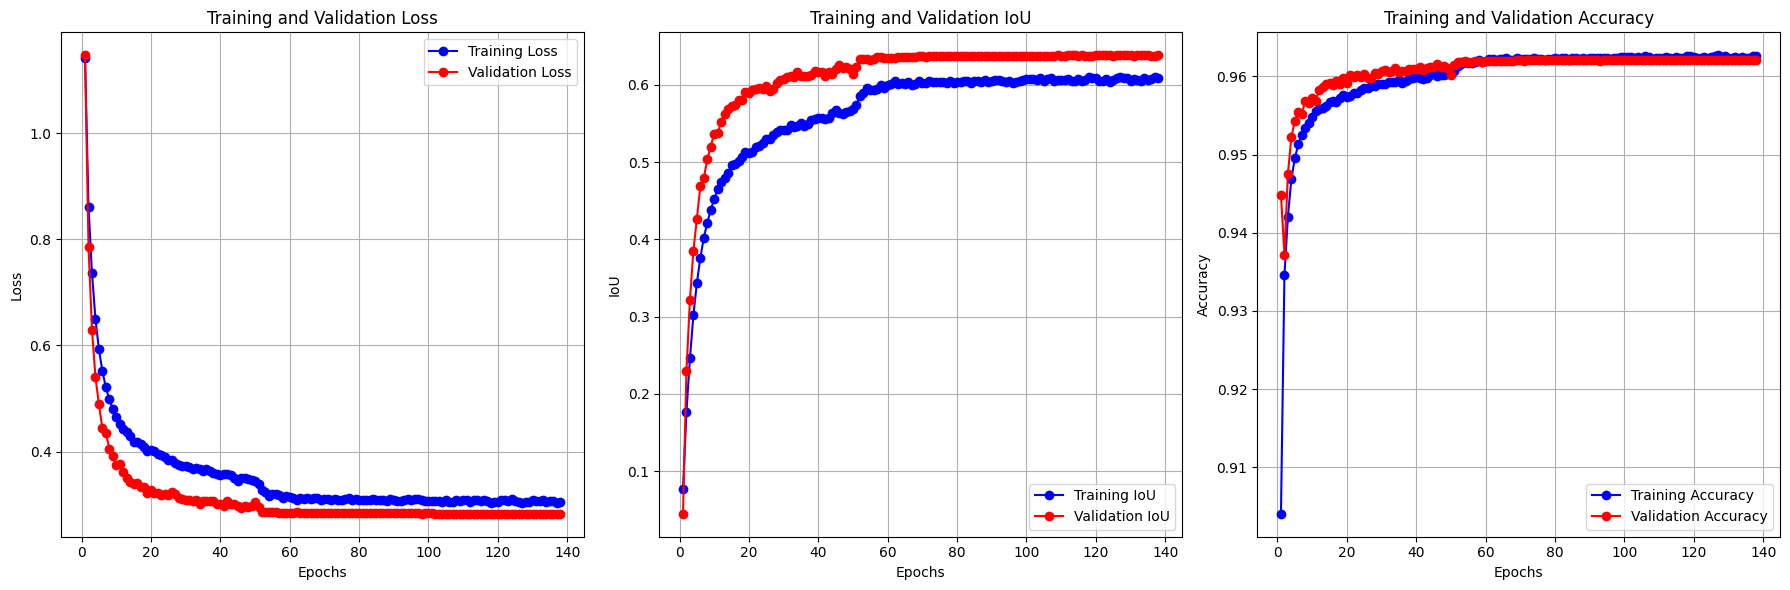

In [35]:
# --- 9. Plot Training History ---

# Extracting history
loss = history.history['loss']
val_loss = history.history['val_loss']
model_iou = history.history['iou']
val_iou = history.history['val_iou']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Plotting Loss
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plotting IoU (Intersection over Union)
plt.subplot(1, 3, 2)
plt.plot(epochs, model_iou, 'bo-', label='Training IoU')
plt.plot(epochs, val_iou, 'ro-', label='Validation IoU')
plt.title('Training and Validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.grid(True)
plt.legend()

# Plotting Accuracy
plt.subplot(1, 3, 3)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Successfully loaded the best model from: C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\unet_road_lane_best.h5

Displaying sample predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


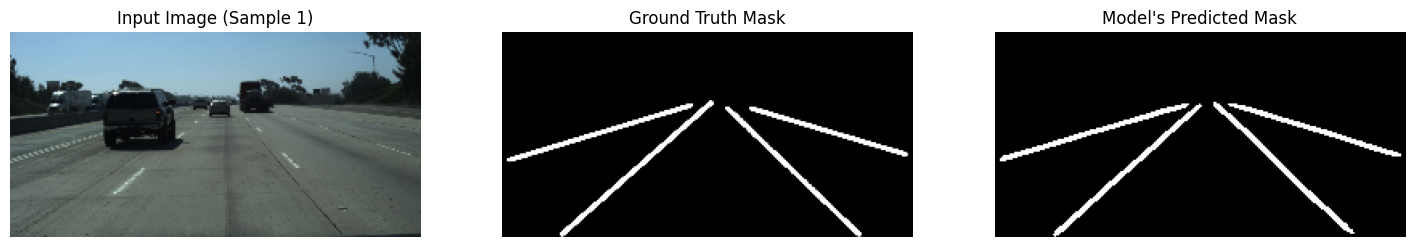

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step


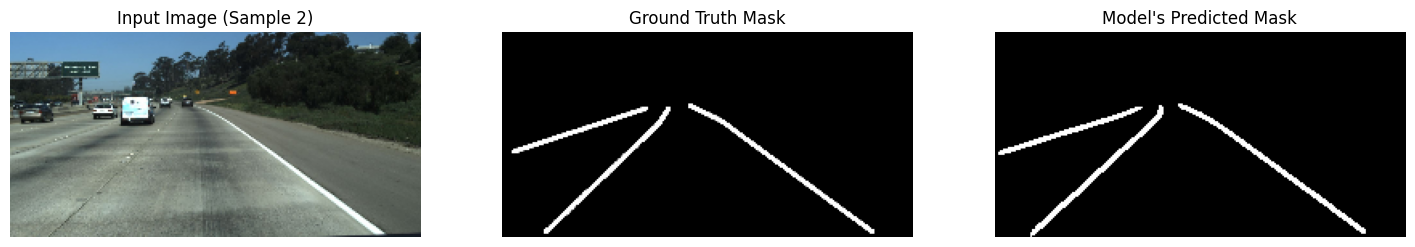

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step


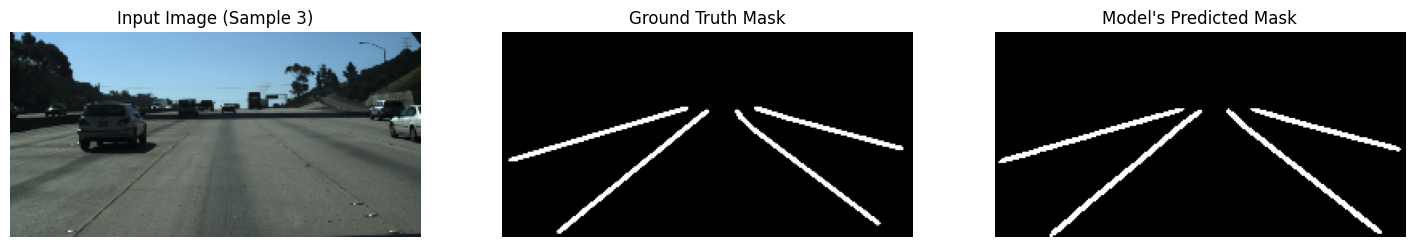

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


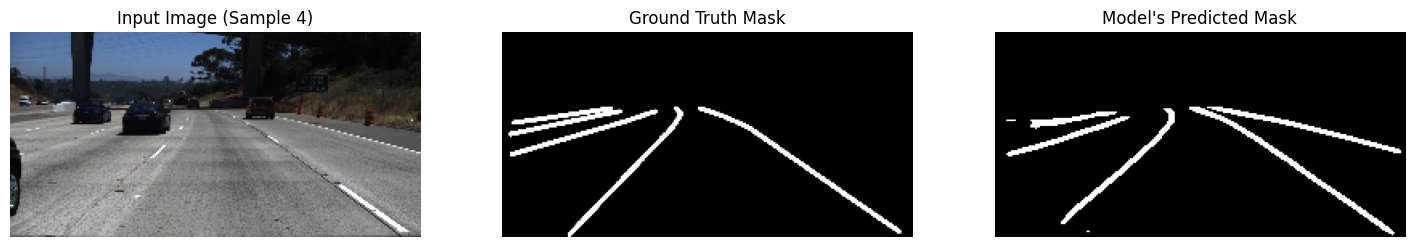

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step


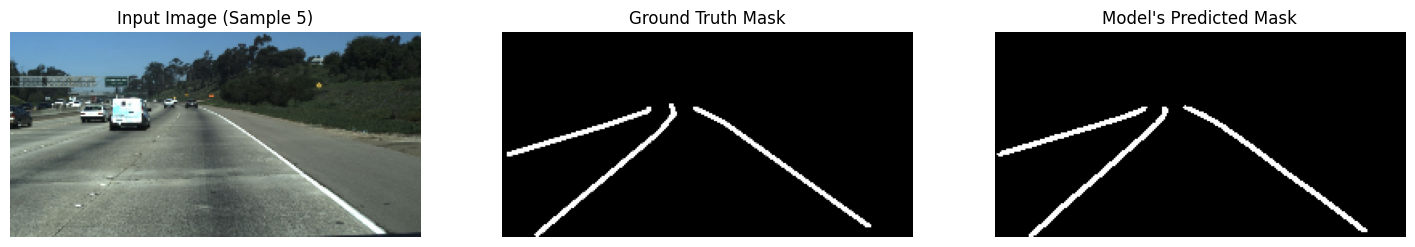

In [22]:
# --- 10. Load Best Model and Visualize Predictions ---

# Define the path to the saved model
model_save_path = r"C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\unet_road_lane_best.h5"

# Create a new model instance and load the best weights
input_shape = (128, 256, 3)
model = build_unet(input_shape)
model.load_weights(model_save_path)

print(f"Successfully loaded the best model from: {model_save_path}")

def visualize_predictions(model, data_generator, num_samples=5):
    """
    Selects a few samples from a data generator and displays the input image,
    the ground truth mask, and the model's predicted mask.
    """
    # Ensure the generator is not empty and num_samples is valid
    if len(data_generator) == 0:
        print("Error: The data generator is empty.")
        return

    num_samples = min(num_samples, len(data_generator))

    print("\nDisplaying sample predictions...")

    for i in range(num_samples):
        # The generator returns batches, so we take the first image from the i-th batch
        # This gives us a nice variety of samples.
        image_batch, true_mask_batch = data_generator[i]

        # Get the first image and mask from the batch
        image = image_batch[0]
        true_mask = true_mask_batch[0]

        # The model expects a batch dimension, so we add it with np.expand_dims
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]

        # --- Plotting ---
        plt.figure(figsize=(18, 6))

        # Plot 1: Original Input Image
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title(f"Input Image (Sample {i+1})")
        plt.axis('off')

        # Plot 2: Ground Truth Mask
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Plot 3: Predicted Mask
        # We use a threshold of 0.5 to convert sigmoid output to a binary mask
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask > 0.5, cmap='gray')
        plt.title("Model's Predicted Mask")
        plt.axis('off')

        plt.show()

# Use the validation generator (val_gen) to visualize predictions on unseen data
visualize_predictions(model, val_gen, num_samples=5)

In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

# --- 1. Define Model Architecture & Load Weights ---

# You MUST redefine the model architecture exactly as it was during training
# so that the saved weights can be loaded correctly.
# Copy the build_unet function from Cell 3 here.
def conv_block(input_tensor, num_filters):
    x = keras.layers.Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    x = keras.layers.Conv2D(num_filters, (3, 3), padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)
    return x

def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = keras.layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input_tensor, skip_features, num_filters):
    x = keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = keras.layers.concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = keras.layers.Input(input_shape)
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.Model(inputs, outputs, name="U-Net")
    return model

# Define the path to your saved model
model_save_path = r"C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\unet_road_lane_best.h5"
input_shape = (128, 256, 3)

# Instantiate the model and load the best weights
model = build_unet(input_shape)
model.load_weights(model_save_path)

print(f"Successfully loaded the best model from: {model_save_path}")


# --- 2. Helper function to process an image for prediction ---
def preprocess_for_prediction(image_path, image_size=(128, 256)):
    """
    Loads and preprocesses a single image for model inference.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # The resize dimensions for cv2 are (width, height)
    img = cv2.resize(img, (image_size[1], image_size[0]))

    # Normalize and add batch dimension
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

Successfully loaded the best model from: C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\unet_road_lane_best.h5


--- Processing Image 1/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


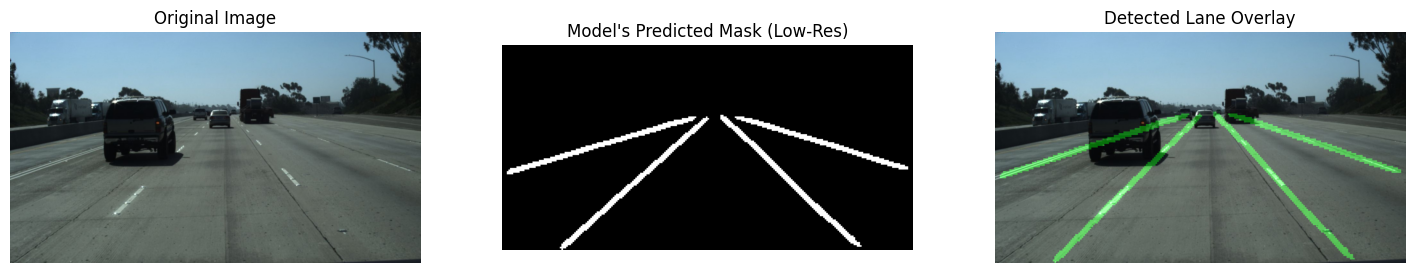

--- Processing Image 2/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 648ms/step


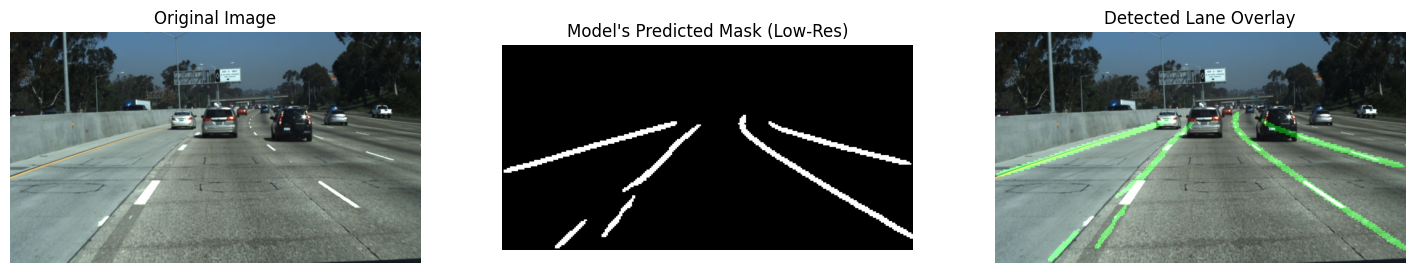

--- Processing Image 3/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step


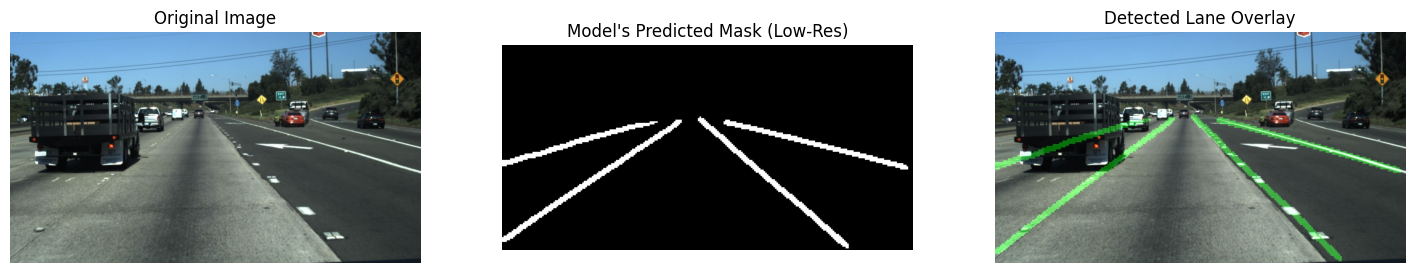

--- Processing Image 4/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step


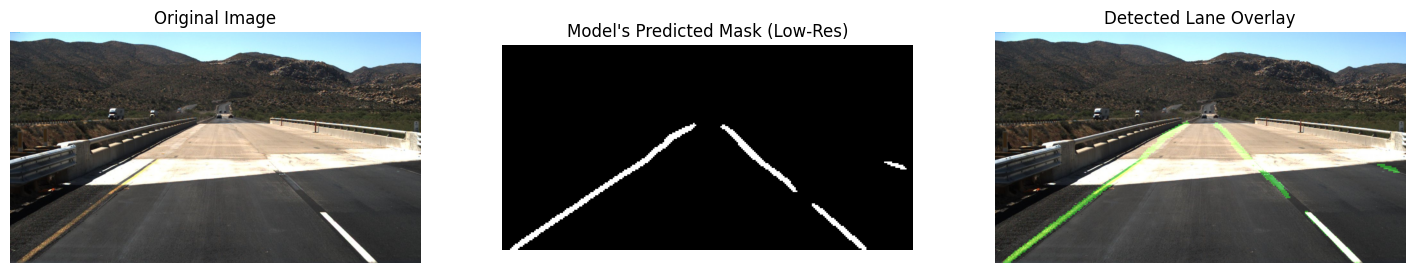

--- Processing Image 5/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 686ms/step


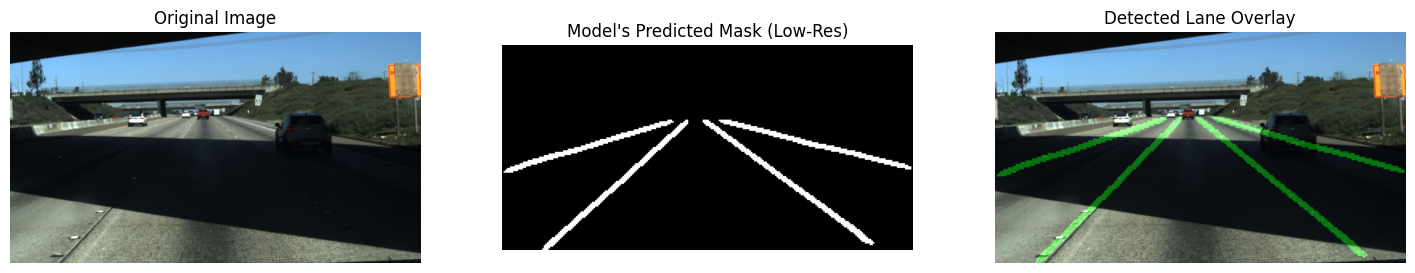

--- Processing Image 6/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


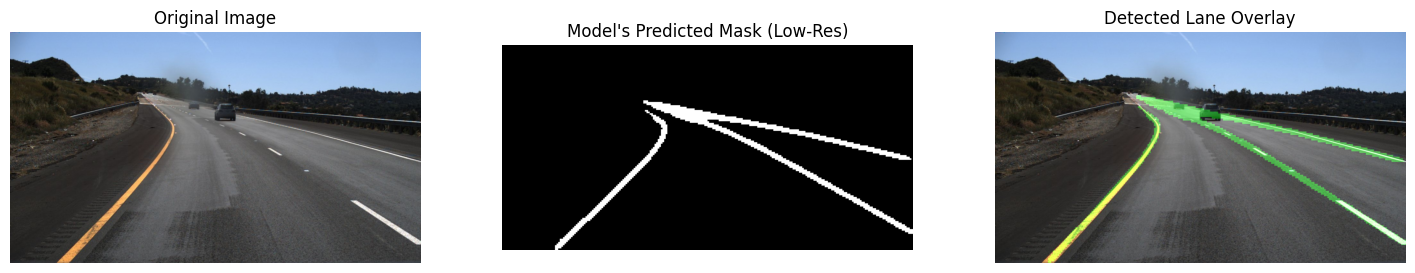

--- Processing Image 7/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


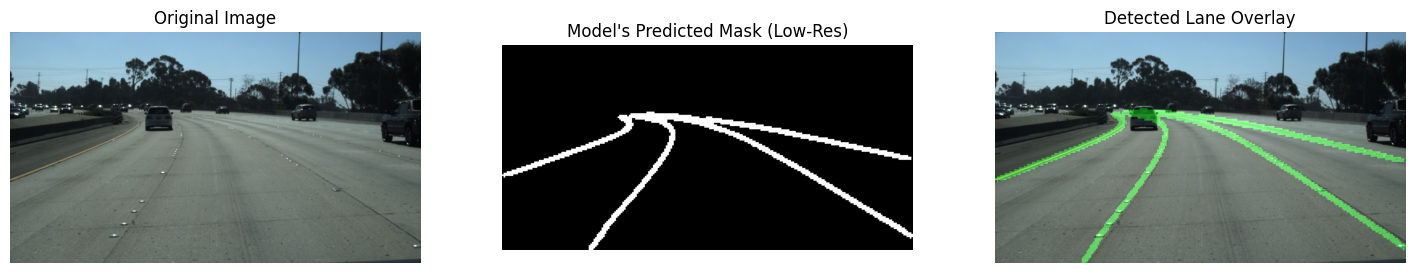

--- Processing Image 8/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


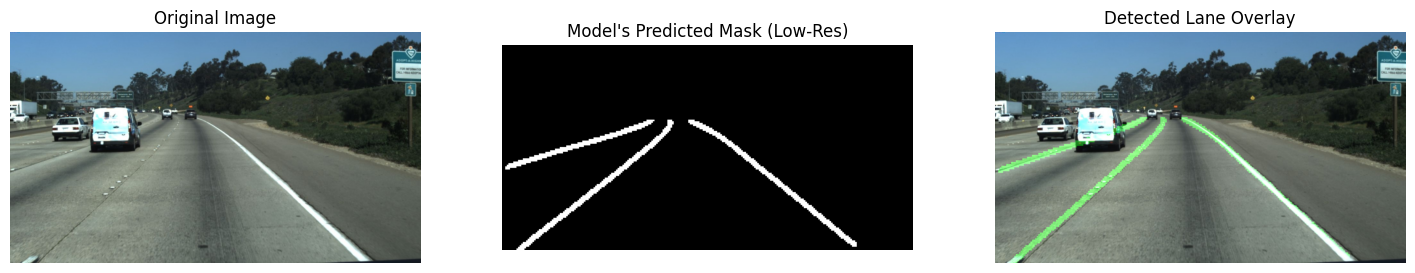

--- Processing Image 9/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step


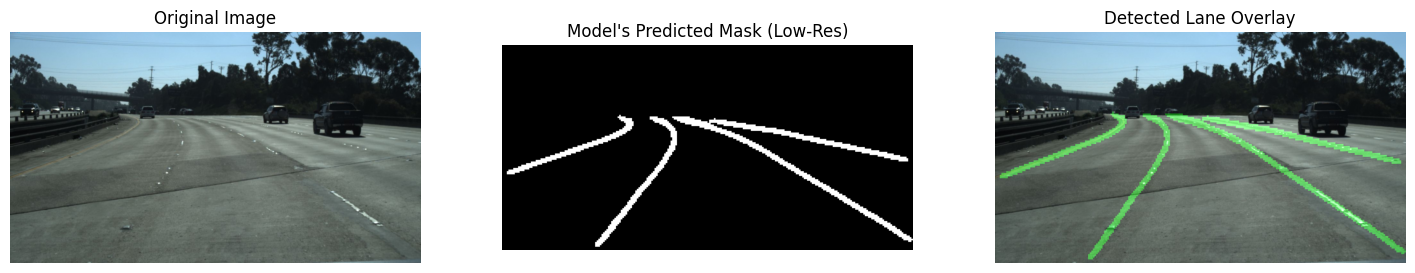

--- Processing Image 10/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step


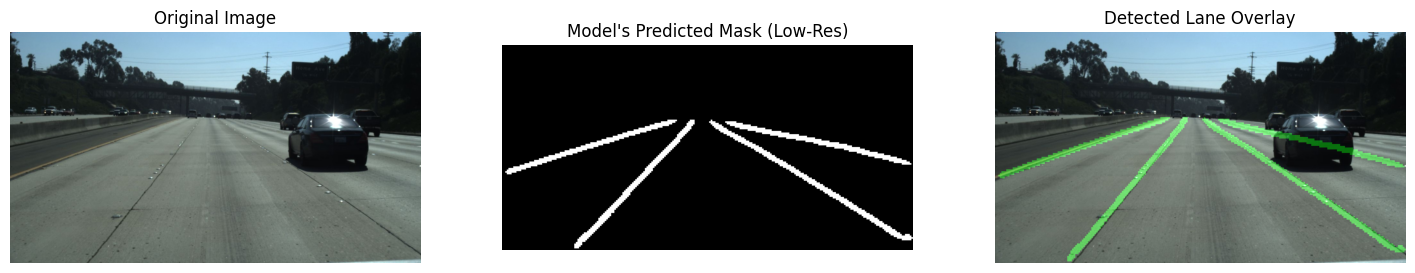

--- Processing Image 11/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


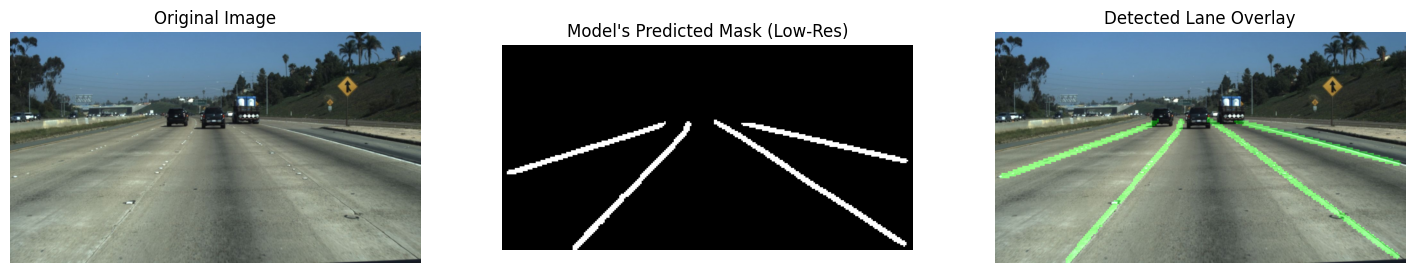

--- Processing Image 12/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


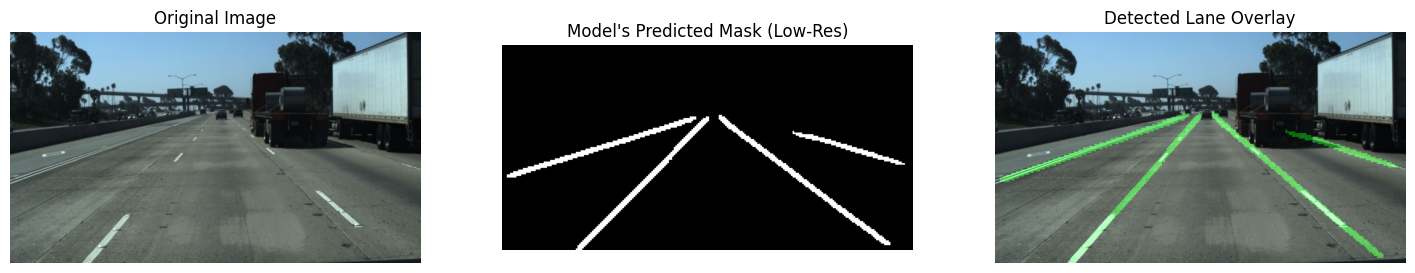

--- Processing Image 13/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step


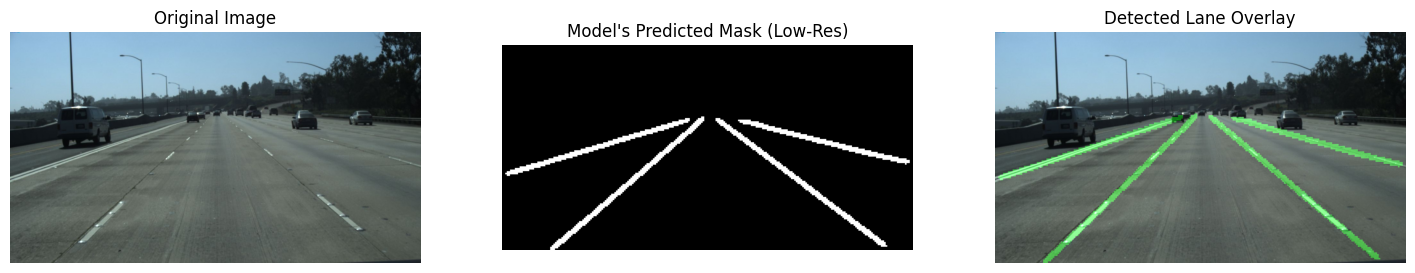

--- Processing Image 14/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


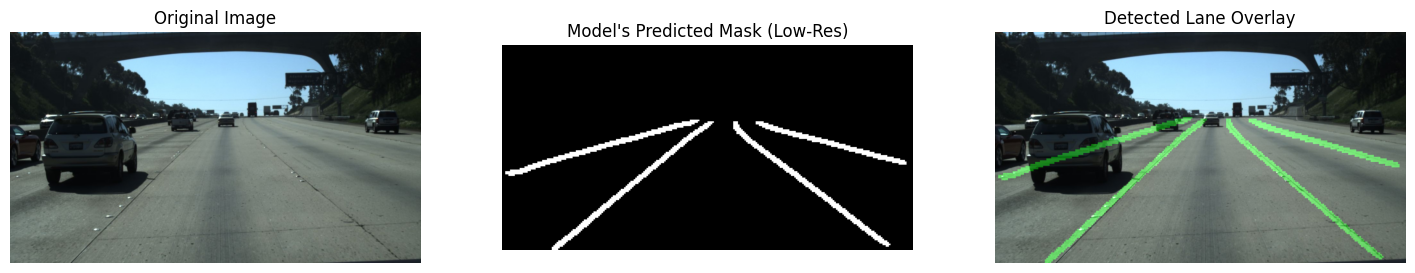

--- Processing Image 15/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step


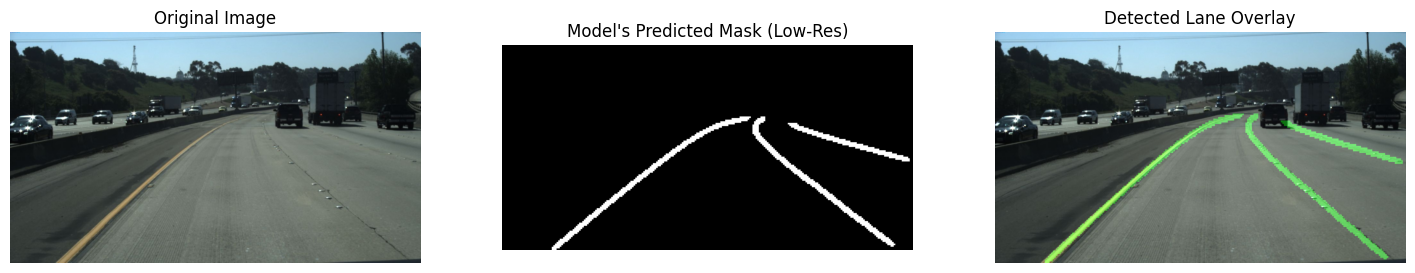

--- Processing Image 16/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step


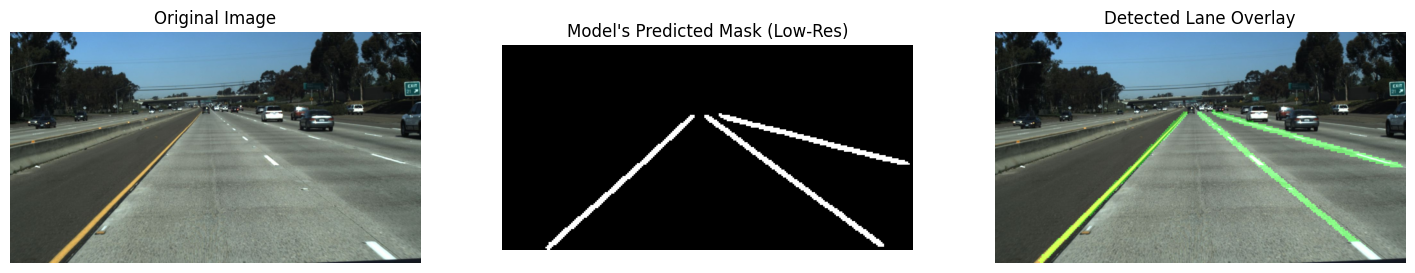

--- Processing Image 17/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 723ms/step


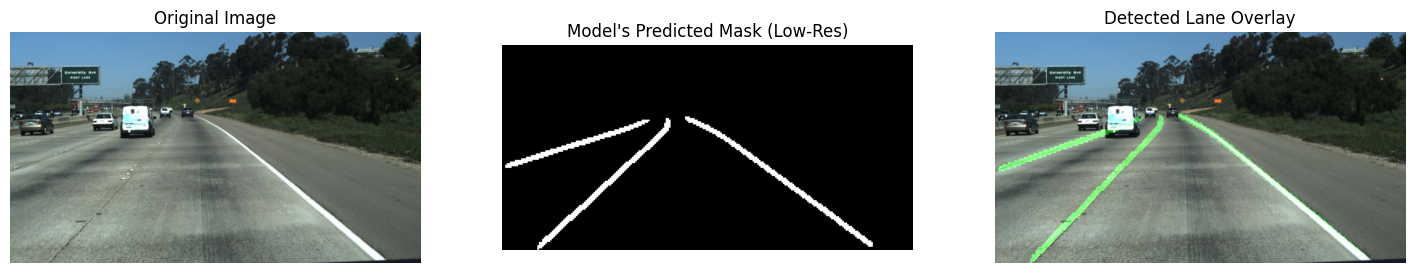

--- Processing Image 18/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step


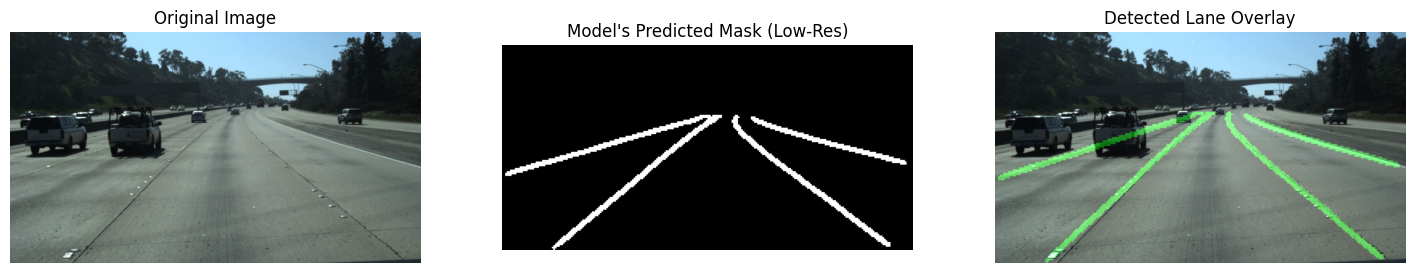

--- Processing Image 19/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step


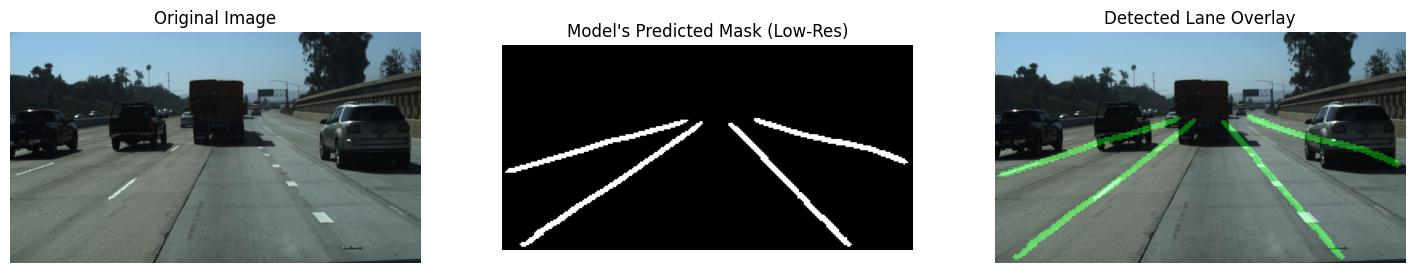

--- Processing Image 20/20 ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step


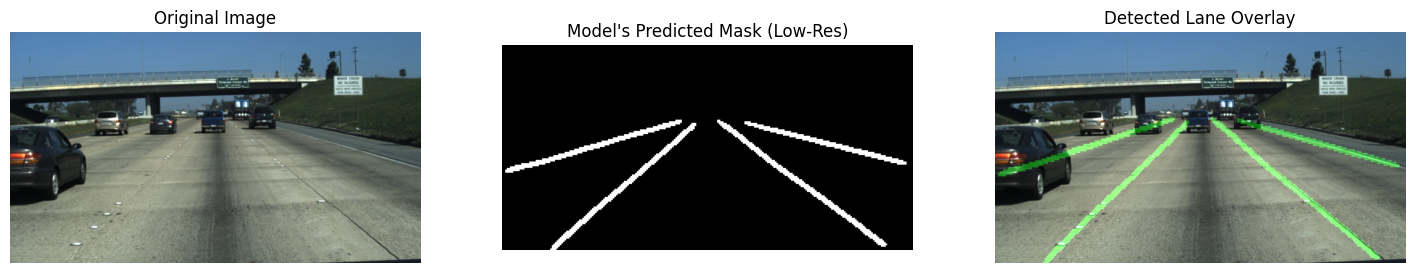

In [25]:
def predict_and_visualize(model, image_path, threshold=0.5):
    """
    Makes a prediction on a single image and creates a visual overlay.
    """
    # --- 1. Load the original image for displaying later ---
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_height, original_width, _ = original_image.shape

    # --- 2. Preprocess and predict ---
    processed_image = preprocess_for_prediction(image_path)
    predicted_mask = model.predict(processed_image)[0]

    # --- 3. Post-process the mask ---
    # Remove the channel dimension and convert to a binary mask
    binary_mask = (predicted_mask[:, :, 0] > threshold).astype(np.uint8)

    # Resize the binary mask back to the original image size
    # Use INTER_NEAREST to avoid creating intermediate pixel values
    full_size_mask = cv2.resize(binary_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

    # --- 4. Create a colored overlay ---
    # Create a green color mask where lanes were detected
    lane_overlay = np.zeros_like(original_image)
    lane_overlay[full_size_mask == 1] = (0, 255, 0)  # Green color for lanes

    # --- 5. Combine the original image with the overlay ---
    # Use cv2.addWeighted to create a transparent overlay effect
    # This blends the original image with the green lane overlay
    result_image = cv2.addWeighted(original_image, 1, lane_overlay, 0.4, 0)

    # --- 6. Display the results ---
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Model's Predicted Mask (Low-Res)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(result_image)
    plt.title("Detected Lane Overlay")
    plt.axis('off')

    plt.show()

# --- Run inference on a sample of images from your validation set ---
# (Remember, X_val was defined in your first cell when you split the data)
num_images_to_show = 20

for i, image_path in enumerate(X_val):
    if i >= num_images_to_show:
        break
    print(f"--- Processing Image {i+1}/{num_images_to_show} ---")
    predict_and_visualize(model, image_path)

In [40]:
# import os
# from tqdm import tqdm # A library to show a nice progress bar

# # --- 1. Define the output directory and create it if it doesn't exist ---
# output_dir = "/New_dataset/prediction/"
# os.makedirs(output_dir, exist_ok=True)
# print(f"Output directory created (or already exists) at: {output_dir}")


# # --- 2. Update the prediction function to save the file instead of displaying it ---
# def predict_and_save(model, image_path, output_path, threshold=0.5):
#     """
#     Makes a prediction on a single image, creates an overlay, and saves the result.
#     """
#     # Load the original image
#     original_image = cv2.imread(image_path)
#     if original_image is None:
#         print(f"Warning: Could not read image at {image_path}. Skipping.")
#         return

#     original_height, original_width, _ = original_image.shape

#     # Preprocess and predict
#     # NOTE: We use the original 'preprocess_for_prediction' function from Cell 6
#     processed_image = preprocess_for_prediction(image_path)
#     predicted_mask = model.predict(processed_image, verbose=0)[0] # Set verbose=0 to keep the output clean

#     # Post-process the mask
#     binary_mask = (predicted_mask[:, :, 0] > threshold).astype(np.uint8)
#     full_size_mask = cv2.resize(binary_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

#     # Create a colored overlay (Green)
#     lane_overlay = np.zeros_like(original_image)
#     lane_overlay[full_size_mask == 1] = [0, 255, 0] # Use a list for BGR color in OpenCV

#     # Combine the original image with the overlay
#     result_image = cv2.addWeighted(original_image, 1, lane_overlay, 0.4, 0)

#     # Save the resulting image
#     cv2.imwrite(output_path, result_image)


# # --- 3. Loop through all images in the validation set and save the predictions ---
# # We will use the `X_val` list which contains the paths to all your validation images.

# print(f"\nStarting prediction for {len(X_val)} validation images...")

# # Using tqdm for a user-friendly progress bar
# for image_path in tqdm(X_val, desc="Processing Images"):
#     try:
#         # Create a unique filename for the output image
#         # e.g., if input is '.../images/abc.jpg', output will be '.../prediction/abc.jpg'
#         base_filename = os.path.basename(image_path)
#         output_path = os.path.join(output_dir, base_filename)

#         # Run the prediction and save the file
#         predict_and_save(model, image_path, output_path)

#     except Exception as e:
#         print(f"Error processing {image_path}: {e}")

# print(f"\n✅ Done! All {len(X_val)} predictions have been saved to the '{output_dir}' folder.")

Output directory created (or already exists) at: /New_dataset/prediction/

Starting prediction for 726 validation images...


Processing Images: 100%|██████████| 726/726 [01:23<00:00,  8.72it/s]


✅ Done! All 726 predictions have been saved to the '/New_dataset/prediction/' folder.


In [26]:
# --- 1. Define the Prediction and Saving Function ---
def predict_and_save(model, image_path, output_path, threshold=0.5):
    """
    Makes a prediction on an image, creates an overlay, and saves the result.
    """
    try:
        # Load the original image
        original_image = cv2.imread(image_path)
        if original_image is None:
            print(f"Warning: Could not read image at {image_path}. Skipping.")
            return

        original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        original_height, original_width, _ = original_image.shape

        # Preprocess the image and make a prediction
        processed_image = preprocess_for_prediction(image_path)
        predicted_mask = model.predict(processed_image, verbose=0)[0]

        # Post-process the mask
        binary_mask = (predicted_mask[:, :, 0] > threshold).astype(np.uint8)
        full_size_mask = cv2.resize(binary_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)

        # Create a green color overlay for the detected lanes
        lane_overlay = np.zeros_like(original_image)
        lane_overlay[full_size_mask == 1] = [17, 159, 50]  # Green in BGR format for saving

        # Combine the original image with the overlay
        result_image = cv2.addWeighted(original_image, 1, lane_overlay, 0.4, 0)

        # Save the final image
        cv2.imwrite(output_path, result_image)

    except Exception as e:
        print(f"Error processing {image_path}: {e}")

# --- 2. Setup Paths and Directories ---

# Combine the training and validation image paths into a single list.
# (X_train and X_val were defined in your first cell when you split the data)
all_image_paths = X_train + X_val
total_images = len(all_image_paths)

# Define the output directory and create it if it doesn't exist
output_dir = r"C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\new_dataset\prediction"
os.makedirs(output_dir, exist_ok=True)

print(f"Found {total_images} total images to process.")
print(f"Predictions will be saved in: {output_dir}")

# --- 3. Loop Through All Images, Predict, and Save ---

# Using a counter for progress reporting
for i, image_path in enumerate(all_image_paths):
    # Print a progress update every 100 images
    if (i + 1) % 100 == 0:
        print(f"Processing image {i + 1}/{total_images}...")

    # Get the original filename (e.g., 'image_1.jpg')
    base_filename = os.path.basename(image_path)

    # Create the full path for the output file
    output_image_path = os.path.join(output_dir, base_filename)

    # Run the prediction and save the result
    predict_and_save(model, image_path, output_image_path)

print(f"\n✅ --- All {total_images} predictions have been generated and saved! ---")

Found 3626 total images to process.
Predictions will be saved in: C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\new_dataset\prediction
Processing image 100/3626...
Processing image 200/3626...
Processing image 300/3626...
Processing image 400/3626...
Processing image 500/3626...
Processing image 600/3626...
Processing image 700/3626...
Processing image 800/3626...
Processing image 900/3626...
Processing image 1000/3626...
Processing image 1100/3626...
Processing image 1200/3626...
Processing image 1300/3626...
Processing image 1400/3626...
Processing image 1500/3626...
Processing image 1600/3626...
Processing image 1700/3626...
Processing image 1800/3626...
Processing image 1900/3626...
Processing image 2000/3626...
Processing image 2100/3626...
Processing image 2200/3626...
Processing image 2300/3626...
Processing image 2400/3626...
Processing image 2500/3626...
Processing image 2600/3626...
Processing image 2700/3626...
Processing image 2800/3626...
Processing image 2900

In [3]:
import cv2
import os
from glob import glob
from tqdm import tqdm

# ========== CONFIGURATION ==========

# Directory where your prediction images are saved
PREDICTION_DIR = r"C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\new_dataset\prediction"

# Desired path for the output video
OUTPUT_VIDEO_PATH = r"C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\lane_detection_presentation.mp4"

# Frames Per Second (FPS) for the output video. 20 is a good speed.
FPS = 20

# ========== 1. Find all prediction images and sort them ==========

# Use glob to find all .jpg files and sort them alphabetically to ensure correct order
image_files = sorted(glob(os.path.join(PREDICTION_DIR, '*.jpg')))

if not image_files:
    print("Error: No images found in the prediction directory!")
    print(f"Please check that images exist in: {PREDICTION_DIR}")
else:
    print(f"Found {len(image_files)} images to create the video.")

    # ========== 2. Get video dimensions from the first image ==========
    
    # Read the first image to determine the width and height for the video
    first_image = cv2.imread(image_files[0])
    height, width, layers = first_image.shape
    frame_size = (width, height)
    
    print(f"Video will be created with resolution: {width}x{height} at {FPS} FPS.")

    # ========== 3. Initialize the Video Writer ==========
    
    # Define the codec and create VideoWriter object. 'mp4v' is the standard codec for .mp4 files.
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    video_writer = cv2.VideoWriter(OUTPUT_VIDEO_PATH, fourcc, FPS, frame_size)

    if not video_writer.isOpened():
        print("Error: Could not open video writer. Check codecs and permissions.")
    else:
        # ========== 4. Loop through images and write to video ==========
        
        print("\nCreating video... This may take a moment.")
        
        # Use tqdm to show a progress bar
        for image_path in tqdm(image_files, desc="Adding frames to video"):
            image = cv2.imread(image_path)
            # Write the frame to the video
            video_writer.write(image)

        # ========== 5. Release the video writer to save the file ==========
        
        video_writer.release()
        
        print(f"\n✅ Success! Video has been saved to:")
        print(os.path.abspath(OUTPUT_VIDEO_PATH))

Found 3626 images to create the video.
Video will be created with resolution: 1280x720 at 20 FPS.

Creating video... This may take a moment.


Adding frames to video: 100%|██████████████████████████████████████████████████████| 3626/3626 [01:15<00:00, 47.78it/s]


✅ Success! Video has been saved to:
C:\Users\Abhishek.Sharma\Desktop\lane_detection_using_unet\lane_detection_presentation.mp4
